# **Caracterización de la demanda de energía a partir de datos AMI**

## **Importar librerías**

In [ ]:

# Data processing
import pandas as pd
import numpy as np
import glob
import holidays

# Machine Learning / Clustering
from sklearn.cluster import KMeans                  
from sklearn.decomposition import PCA             
from sklearn.metrics import davies_bouldin_score    
from sklearn.preprocessing import StandardScaler  

# Time series clustering
import tslearn                                                                         
from tslearn.clustering import KShape, TimeSeriesKMeans                                 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler     

# Outlier detection
from scipy.spatial.distance import cdist
from scipy.spatial.distance import mahalanobis      
from scipy.stats import chi2                      
from numpy.linalg import inv                        

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px                          
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.cm as cm

# Config
import warnings
import gc
warnings.filterwarnings("ignore")
plt.style.use("ggplot")


## **ETL 1**

### **Importar bases de datos**

#### **Base de datos AMI**

In [ ]:
               
pattern = "EV_BINNINGCONV60_*.dat"                      # Ruta base donde están almacenados los archivos de datos AMI
file_list = glob.glob(pattern)                      

AMIall = pd.concat([                                    # Leer todos los archivos y concatenarlos en un único DataFrame
    pd.read_csv(file, sep='|', header=1, converters={'Start Date': str})
    for file in file_list
], ignore_index=True)

print(AMIall.shape)


(1741375, 59)


#### **Verificación de registros duplicados en AMIall**

In [ ]:

duplicados = AMIall[AMIall.duplicated()]
print(f"Total duplicados: {duplicados.shape[0]}")
print(duplicados.head())


Total duplicados: 0
Empty DataFrame
Columns: [DT, Meter Number, Customer Account Number, Serial Number, Port, Channel, Conversion Factor, Data Type, Start Date, Start Time, QC#1, Interval#1, QC#2, Interval#2, QC#3, Interval#3, QC#4, Interval#4, QC#5, Interval#5, QC#6, Interval#6, QC#7, Interval#7, QC#8, Interval#8, QC#9, Interval#9, QC#10, Interval#10, QC#11, Interval#11, QC#12, Interval#12, QC#13, Interval#13, QC#14, Interval#14, QC#15, Interval#15, QC#16, Interval#16, QC#17, Interval#17, QC#18, Interval#18, QC#19, Interval#19, QC#20, Interval#20, QC#21, Interval#21, QC#22, Interval#22, QC#23, Interval#23, QC#24, Interval#24, Unnamed: 58]
Index: []

[0 rows x 59 columns]


In [ ]:

AMIall.drop_duplicates(inplace=True)


#### **Verificación de valores faltantes en AMIall y conteo por columna**

In [ ]:

print(AMIall.isnull().sum())


DT                               0
Meter Number                   316
Customer Account Number          0
Serial Number                    0
Port                             1
Channel                          1
Conversion Factor                1
Data Type                       80
Start Date                       0
Start Time                       1
QC#1                             1
Interval#1                       1
QC#2                             1
Interval#2                       1
QC#3                             1
Interval#3                       1
QC#4                             1
Interval#4                       1
QC#5                             1
Interval#5                       1
QC#6                             1
Interval#6                       1
QC#7                             1
Interval#7                       1
QC#8                             1
Interval#8                       1
QC#9                             1
Interval#9                       1
QC#10               

#### **Base de datos Clientes**

In [ ]:

Clientes = pd.read_excel('clientes 112021.xlsx')
Clientes = Clientes[['PERIODO', 'PRODUCTO', 'ZONA', 'MUNICIPIO', 'UBICACION', 'CATEGORIA', 'SUBCATEGORIA']]     # Selección de columnas relevantes asociadas al cliente, dejando de lado información de los medidores
print(Clientes.shape)
Clientes.head()



(37899, 7)


PERIODO   PRODUCTO             ZONA MUNICIPIO UBICACION    CATEGORIA  \
0   112021  225433263  S.O ZONA CENTRO   POPAYÁN    Urbano   INDUSTRIAL   
1   112021  225542012  S.O ZONA CENTRO   POPAYÁN    Urbano    COMERCIAL   
2   112021  230075437     S.O ZONA SUR    BALBOA     Rural  RESIDENCIAL   
3   112021  233480316  S.O ZONA CENTRO   MORALES     Rural  RESIDENCIAL   
4   112021  233481103  S.O ZONA CENTRO   MORALES     Rural  RESIDENCIAL   

  SUBCATEGORIA  
0   INDUSTRIAL  
1    COMERCIAL  
2    ESTRATO 1  
3    ESTRATO 1  
4    ESTRATO 1

#### **Verificación de las categorías únicas de Municipio, Ubicación, Categoría y Subcategoría**

In [ ]:

print("MUNICIPIO:", Clientes['MUNICIPIO'].unique(), '\n')
print("UBICACION:", Clientes['UBICACION'].unique(), '\n')
print("CATEGORIA:", Clientes['CATEGORIA'].unique(), '\n')
print("SUBCATEGORIA:", Clientes['SUBCATEGORIA'].unique())


MUNICIPIO: ['POPAYÁN' 'BALBOA' 'MORALES' 'SILVIA' 'JAMBALÓ' 'EL TAMBO' 'TIMBÍO'
 'GUACHENÉ' 'TORIBIO' 'BUENOS AIRES' 'SUÁREZ' 'BOLÍVAR' 'PUERTO TEJADA'
 'ARGELIA' 'CALDONO' 'CALOTO' 'SANTANDER DE QUILICHAO' 'MERCADERES'
 'FLORENCIA' 'PIENDAMÓ-TUNIA' 'LA SIERRA' 'ROSAS' 'PURACÉ'] 

UBICACION: ['Urbano' 'Rural'] 

CATEGORIA: ['INDUSTRIAL' 'COMERCIAL' 'RESIDENCIAL' 'OFICIAL' 'ALUM PUBLICO'] 

SUBCATEGORIA: ['INDUSTRIAL' 'COMERCIAL' 'ESTRATO 1' 'ESTRATO 2' 'OFICIAL' 'ESTRATO 3'
 'ESTRATO 4' 'ESTRATO 5' 'EXENTO CONTRIB' 'ESTRATO 6' 'ALUM PUBLICO'
 'COMERCIAL 24H']


#### **Base de datos de medidores AMI**

In [ ]:

medidores = pd.read_excel('TWACS_MedidoresInicializados13012022.xlsx')
print(medidores.shape)
medidores.head()


(38044, 7)


PRODUCTO NUMERO_MEDIDOR  SERIAL_TWACS  SERIAL_CAJA_SIM  SLOT  PUERTO  \
0  244891826         582695      19307496          74902.0   1.0       0   
1  244891826         582694      19307518          74902.0   2.0       0   
2  244891826         582698      19307477          74902.0   3.0       0   
3  244891826         582705      19307477          74902.0  12.0       3   
4  256805358         491425      99196698          72089.0   5.0       1   

                  obs  
0  medida concentrada  
1  medida concentrada  
2  medida concentrada  
3  medida concentrada  
4  medida concentrada

#### **Tipos de datos de las columnas del Dataframe de medidores**

In [ ]:

print(medidores.dtypes)


PRODUCTO            object
NUMERO_MEDIDOR      object
SERIAL_TWACS         int64
SERIAL_CAJA_SIM    float64
SLOT               float64
PUERTO               int64
obs                 object
dtype: object


In [ ]:

medidores['Channel'] = medidores['PUERTO'] + 1              # Crea una serie channel que corresponde a puerto + 1


#### **Verificación de columnas comunes entre los Dataframes medidores y clientes y luego combinar ambos Dataframes en un único Dataframe**

In [ ]:

# Encuentra columnas comunes entre medidores y Clientes 
columnas_comunes = medidores.columns.intersection(Clientes.columns)
print("Columnas comunes:", columnas_comunes.tolist())

# Realiza el merge usando las columnas comunes
dfclientes = pd.merge(medidores, Clientes, on=columnas_comunes.tolist(), how='inner')

print("Tamaño de dfclientes:", dfclientes.shape)
print(dfclientes.head())


Columnas comunes: ['PRODUCTO']
Tamaño de dfclientes: (35274, 14)
    PRODUCTO NUMERO_MEDIDOR  SERIAL_TWACS  SERIAL_CAJA_SIM  SLOT  PUERTO  \
0  244891826         582695      19307496          74902.0   1.0       0   
1  244891826         582694      19307518          74902.0   2.0       0   
2  244891826         582698      19307477          74902.0   3.0       0   
3  244891826         582705      19307477          74902.0  12.0       3   
4  256805358         491425      99196698          72089.0   5.0       1   

                  obs  Channel  PERIODO             ZONA MUNICIPIO UBICACION  \
0  medida concentrada        1   112021  S.O ZONA CENTRO  EL TAMBO     Rural   
1  medida concentrada        1   112021  S.O ZONA CENTRO  EL TAMBO     Rural   
2  medida concentrada        1   112021  S.O ZONA CENTRO  EL TAMBO     Rural   
3  medida concentrada        4   112021  S.O ZONA CENTRO  EL TAMBO     Rural   
4  medida concentrada        2   112021   S.O ZONA NORTE   TORIBIO     Rural  

### **Limpieza de datos**

In [12]:

AMIall["Data Type"].unique()


array(['Active Energy Wh', 'Inductive Reactive Energy Varh',
       'Active Energy', nan, 'RMS Voltage in Volts',
       'Secure Energy in Wh', 'Active Energy WH', 'Reactive Energry VARH'],
      dtype=object)

#### **Dataframe que contenga únicamente los registros de energía activa, considerando: ["Active Energy Wh", "Secure Energy in Wh", "Active Energy WH", "Active Energy"].**

In [ ]:

# Filtrar los registros de energía activa
tipos_energia_activa = ["Active Energy Wh", "Secure Energy in Wh", "Active Energy WH", "Active Energy"]
dfkWh = AMIall[AMIall['Data Type'].isin(tipos_energia_activa)]

# Imprimir el tamaño
print("Tamaño de dfkWh:", dfkWh.shape)


Tamaño de dfkWh: (1116186, 59)


In [ ]:

dfkWh = dfkWh.rename(columns={f'Interval#{i}': f'I{i}' for i in range(1, 25)})  # Renombrar columnas intervalo (hora)
dfkWh.head(3)


Tamaño de dfkWh: (1116186, 59)


In [ ]:

# Selección de datos válidos (Filtra código de calidad QC=3)
columns = [f"QC#{i}" for i in range(1, 25)]             # Lista de columnas de calidad
dfkWh = dfkWh.loc[(dfkWh[columns] == 3).all(axis=1)]    # Filtrar y selecciona las filas donde todas las 24 horas tienen calidad 3
dfkWh.shape     # Analizar qué tanto se está descartando


(874772, 59)

In [ ]:

# Eliminación de características (Eliminar columnas)
cols_to_drop = ['DT', 'Port', 'Conversion Factor', 'Start Time', 'Unnamed: 58'] + [f'QC#{i}' for i in range(1, 25)]
dfkWh = dfkWh.drop(cols_to_drop, axis=1)
print(dfkWh.shape)
dfkWh.head(3)


(874772, 30)


Meter Number  Customer Account Number  Serial Number  Channel  \
160       532685                652828577       19306164      1.0   
161       532685                652828577       19306164      2.0   
162       532685                652828577       19306164      3.0   

         Data Type Start Date    I1    I2    I3    I4  ...   I15   I16   I17  \
160  Active Energy     011221  0.16  0.24  0.32  0.24  ...  0.40  0.48  0.72   
161  Active Energy     011221  0.16  0.16  0.08  0.00  ...  1.12  0.08  0.00   
162  Active Energy     011221  0.16  0.08  0.00  0.08  ...  0.16  0.16  0.24   

      I18   I19   I20   I21   I22   I23   I24  
160  0.56  0.40  0.48  0.64  0.56  0.64  0.40  
161  0.08  0.24  0.08  0.16  0.32  0.16  0.24  
162  0.08  0.24  0.24  0.24  0.16  0.24  0.08  

[3 rows x 30 columns]

### **Transformación de datos**

In [ ]:

# Cambiar formato
interval_cols = [f'I{i}' for i in range(1, 25)]
dfkWh = dfkWh.astype({col: float for col in interval_cols})     # Intervalos horarios 'I1' a 'I24' → Se convierten explícitamente a float
dfkWh['Serial Number'] = dfkWh['Serial Number'].astype(object)  # Se fuerza a tipo object


In [ ]:

# Unificar bases de datos: Energía activa con calidad Q=3 combinada con el df clientes y medidores AMI
dfkWh = pd.merge(dfkWh, dfclientes,
                 left_on=['Serial Number','Channel'],  
                 right_on=['SERIAL_TWACS','Channel'],   
                 how='left')   
print(dfkWh.shape)
dfkWh.head(3)     


(874772, 43)


Meter Number  Customer Account Number Serial Number  Channel      Data Type  \
0       532685                652828577      19306164      1.0  Active Energy   
1       532685                652828577      19306164      2.0  Active Energy   
2       532685                652828577      19306164      3.0  Active Energy   

  Start Date    I1    I2    I3    I4  ...  SERIAL_CAJA_SIM  SLOT  PUERTO  \
0     011221  0.16  0.24  0.32  0.24  ...          74261.0   1.0     0.0   
1     011221  0.16  0.16  0.08  0.00  ...          74261.0   4.0     1.0   
2     011221  0.16  0.08  0.00  0.08  ...          74261.0   7.0     2.0   

                  obs   PERIODO             ZONA  MUNICIPIO  UBICACION  \
0  medida concentrada  112021.0  S.O ZONA CENTRO    POPAYÁN     Urbano   
1  medida concentrada  112021.0  S.O ZONA CENTRO    POPAYÁN     Urbano   
2  medida concentrada  112021.0  S.O ZONA CENTRO    POPAYÁN     Urbano   

     CATEGORIA  SUBCATEGORIA  
0  RESIDENCIAL     ESTRATO 2  
1  RESIDENCIAL     ESTRATO 3  
2  RESIDENCIAL     ESTRATO 3  

[3 rows x 43 columns]

In [ ]:

# Cambiar a formato fecha
dfkWh["Start Date"] = pd.to_datetime(dfkWh["Start Date"], format='%m%d%y')
   

#### **Conservar únicamente los clientes Residenciales**

In [ ]:

dfkWh = dfkWh[dfkWh['CATEGORIA'] == 'RESIDENCIAL']
print(dfkWh.shape)


(749070, 43)


In [ ]:

# Cambio de estructura del dataframe
id_vars = ['Meter Number', 'Customer Account Number', 'Serial Number', 'Channel',
           'Data Type', 'Start Date', 'PRODUCTO', 'NUMERO_MEDIDOR',
           'SERIAL_TWACS', 'SERIAL_CAJA_SIM', 'SLOT', 'PUERTO', 'obs', 'PERIODO',
           'ZONA', 'MUNICIPIO', 'UBICACION', 'CATEGORIA', 'SUBCATEGORIA']        
value_vars_1 = dfkWh.loc[:, dfkWh.columns.str.startswith('I')].columns.tolist()   # Selecciona todas las columnas que comienzan con "I" (como I1, I2, ..., I24), que representan la demanda horaria en intervalos de 1 hora

chunks = []
chunk_size = 1000
for i in range(0, len(dfkWh), chunk_size):
    df_chunk = dfkWh.iloc[i:i+chunk_size]
    melted = pd.melt(df_chunk, id_vars=id_vars, value_vars=value_vars_1,               # Una fila se convierte en 24
                     var_name='Hour', value_name='Demand')                             # 'Hour': Contendrá los nombres originales de las columnas (I1, I2, ..., I24). 'Demand': Contendrá los valores numéricos que antes estaban dispersos en esas columnas
    melted['Hour'] = melted['Hour'].str.extract('(\d+)', expand=False).astype('uint8') # Elimina cualquier carácter no numérico de la columna Hour
    chunks.append(melted)

df_clear = pd.concat(chunks, ignore_index=True)

print(df_clear.shape)
df_clear.head(3)


(17977680, 21)


Meter Number  Customer Account Number Serial Number  Channel      Data Type  \
0       532685                652828577      19306164      1.0  Active Energy   
1       532685                652828577      19306164      2.0  Active Energy   
2       532685                652828577      19306164      3.0  Active Energy   

  Start Date   PRODUCTO NUMERO_MEDIDOR  SERIAL_TWACS  SERIAL_CAJA_SIM  ...  \
0 2021-01-12  652828577         532685    19306164.0          74261.0  ...   
1 2021-01-12  648992632         533500    19306164.0          74261.0  ...   
2 2021-01-12  652825126         532693    19306164.0          74261.0  ...   

   PUERTO                 obs   PERIODO             ZONA MUNICIPIO UBICACION  \
0     0.0  medida concentrada  112021.0  S.O ZONA CENTRO   POPAYÁN    Urbano   
1     1.0  medida concentrada  112021.0  S.O ZONA CENTRO   POPAYÁN    Urbano   
2     2.0  medida concentrada  112021.0  S.O ZONA CENTRO   POPAYÁN    Urbano   

     CATEGORIA SUBCATEGORIA Hour  Demand  
0  RESIDENCIAL    ESTRATO 2    1    0.16  
1  RESIDENCIAL    ESTRATO 3    1    0.16  
2  RESIDENCIAL    ESTRATO 3    1    0.16  

[3 rows x 21 columns]

In [ ]:

df_clear.groupby(['PRODUCTO','SERIAL_TWACS'])['PUERTO'].nunique().max()   # Serie con el número de puertos distintos por cada combinación de PRODUCTO y SERIAL_TWACS


1

In [ ]:

df_clear['PRODUCTO_SERIAL_TWACS'] = df_clear['PRODUCTO'].astype(str) + '_' + df_clear['SERIAL_TWACS'].astype(str)   # Crea una clave compuesta uniendo las columnas PRODUCTO y SERIAL_TWACS


In [ ]:

# Selección de características relevantes en el análisis
df_clear = df_clear[['PRODUCTO', 'PRODUCTO_SERIAL_TWACS', 'Start Date', 'ZONA', 'MUNICIPIO', 'UBICACION', 'SUBCATEGORIA', 'Hour', 'Demand']]
df_clear.head(3)


PRODUCTO PRODUCTO_SERIAL_TWACS Start Date             ZONA MUNICIPIO  \
0  652828577  652828577_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
1  648992632  648992632_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
2  652825126  652825126_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   

  UBICACION SUBCATEGORIA  Hour  Demand  
0    Urbano    ESTRATO 2     1    0.16  
1    Urbano    ESTRATO 3     1    0.16  
2    Urbano    ESTRATO 3     1    0.16

In [ ]:

df_clear['Year'] = df_clear['Start Date'].dt.year                                                           # Generación de columnas tipo calendario
df_clear['Month'] = df_clear['Start Date'].dt.month
df_clear['Day'] = df_clear['Start Date'].dt.day

df_clear['Date'] = pd.to_datetime(df_clear[['Year','Month','Day','Hour']])                                  # Fecha-hora combinada (Date)
df_clear['Hour'] = df_clear['Date'].dt.hour

# Generación de columna Año-Mes
df_clear['Year_Month'] = df_clear['Year'].astype(str) + '-' + df_clear['Month'].astype(str)                 
df_clear['Year_Month'] = df_clear['Year_Month'].astype('category')
df_clear['Year_Month'] = df_clear['Year_Month'].cat.set_categories(                                         
    ['2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3', '2021-4'], ordered=True)      # Si en la columna hay valores que no estén en esa lista, se convertirán en NaN.

# Generación de columna Día de la semana
df_clear['day_of_week'] = df_clear['Date'].dt.day_name()
df_clear['day_of_week'] = df_clear['day_of_week'].astype('category')
df_clear['day_of_week'] = df_clear['day_of_week'].cat.set_categories(                                      
         ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Generación de columna festivo
col_holidays = holidays.CountryHoliday('COL')                                                               # usando el paquete holidays con calendario colombiano.
df_clear['Holiday'] = df_clear['Date'].apply(lambda x: True if x in col_holidays else False)

# Generación de columna Día de la semana + festivo
conditions = [                                                                                              # se crean 8 condiciones booleanas
    df_clear['Holiday'],                                                                                    # Si es festivo (Holiday == True)
    (df_clear['day_of_week'] == 'Monday') & ~df_clear['Holiday'],                                           # Si es lunes y no es festivo
    (df_clear['day_of_week'] == 'Tuesday') & ~df_clear['Holiday'],                                          
    (df_clear['day_of_week'] == 'Wednesday') & ~df_clear['Holiday'],
    (df_clear['day_of_week'] == 'Thursday') & ~df_clear['Holiday'],
    (df_clear['day_of_week'] == 'Friday') & ~df_clear['Holiday'],
    (df_clear['day_of_week'] == 'Saturday') & ~df_clear['Holiday'],
    (df_clear['day_of_week'] == 'Sunday') & ~df_clear['Holiday']
]
dia_semana = ['Holiday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']      # Etiquetas asociadas a las condiciones
df_clear['day_of_week_Holi'] = np.select(conditions, dia_semana, default='Monday')                          # Evalúa las condiciones en orden y asigna el valor correspondiente de dia_semana.
df_clear['day_of_week_Holi'] = pd.Categorical(df_clear['day_of_week_Holi'],
                                                categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                                            'Friday', 'Saturday', 'Sunday', 'Holiday'], ordered=True)       # Convierte la columna en un tipo categórico ordenado

# Generación de columna Día laboral, Sábado, Domingo y festivo
conditions2 = [
    df_clear['Holiday'],                                                                                                # Devuelve True para las filas donde la fecha es festiva.
    (df_clear['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']) & ~df_clear['Holiday']),    # Selecciona los días lunes a viernes que no son festivos.
    (df_clear['day_of_week'] == 'Saturday') & ~df_clear['Holiday'],                                                     # Sábados que no son festivos.
    (df_clear['day_of_week'] == 'Sunday') & ~df_clear['Holiday']                                                        # Domingos que no son festivos.
]
tipo_dia = ['Holiday', 'Weekday', 'Saturday', 'Sunday']
df_clear['Type_of_day_Holi'] = np.select(conditions2, tipo_dia, default='Weekday')
df_clear['Type_of_day_Holi'] = pd.Categorical(df_clear['Type_of_day_Holi'],
                                              categories=['Weekday', 'Saturday', 'Sunday', 'Holiday'], ordered=True)  # clasifica cada observación según el tipo de día (festivo, día hábil, sábado o domingo)

# Generación de columna Tipo de día y festivo conjuntamente
df_clear['Type_week_weekend'] = df_clear['Type_of_day_Holi'].copy()
df_clear.Type_week_weekend.replace({'Holiday':'Sunday'}, inplace=True)      # Aquí se hace un reemplazo de los valores 'Holiday' por 'Sunday' en la nueva columna Type_week_weekend. Esto significa que todos los días festivos se tratarán como si fueran domingos en el análisis posterior.     
         

#### **Verificación de las nuevas columnas tipo calendario hayan sido creadas y sus categorías asociadas**

In [ ]:

print(df_clear.shape)        
df_clear.sample(5)           # Muestra aleatoria de 5 filas

print(df_clear.columns.tolist())

print("Categorías en 'Year_Month':", df_clear['Year_Month'].cat.categories)
print("Categorías en 'day_of_week':", df_clear['day_of_week'].cat.categories)
print("Categorías en 'day_of_week_Holi':", df_clear['day_of_week_Holi'].cat.categories)
print("Categorías en 'Type_of_day_Holi':", df_clear['Type_of_day_Holi'].cat.categories)


(17977680, 19)
['PRODUCTO', 'PRODUCTO_SERIAL_TWACS', 'Start Date', 'ZONA', 'MUNICIPIO', 'UBICACION', 'SUBCATEGORIA', 'Hour', 'Demand', 'Year', 'Month', 'Day', 'Date', 'Year_Month', 'day_of_week', 'Holiday', 'day_of_week_Holi', 'Type_of_day_Holi', 'Type_week_weekend']
Categorías en 'Year_Month': Index(['2020-9', '2020-10', '2020-11', '2020-12', '2021-1', '2021-2', '2021-3',
       '2021-4'],
      dtype='object')
Categorías en 'day_of_week': Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'],
      dtype='object')
Categorías en 'day_of_week_Holi': Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'Holiday'],
      dtype='object')
Categorías en 'Type_of_day_Holi': Index(['Weekday', 'Saturday', 'Sunday', 'Holiday'], dtype='object')


In [ ]:

df_clear['Demand'] = df_clear['Demand'].replace(0, np.nan)      # Reemplazar los valores de 0 por NaN


### **Verificación de la existencia de registros duplicados**

In [ ]:

duplicados = df_clear.duplicated()
print("Número de registros duplicados:", duplicados.sum())


Número de registros duplicados: 0


## **EDA**

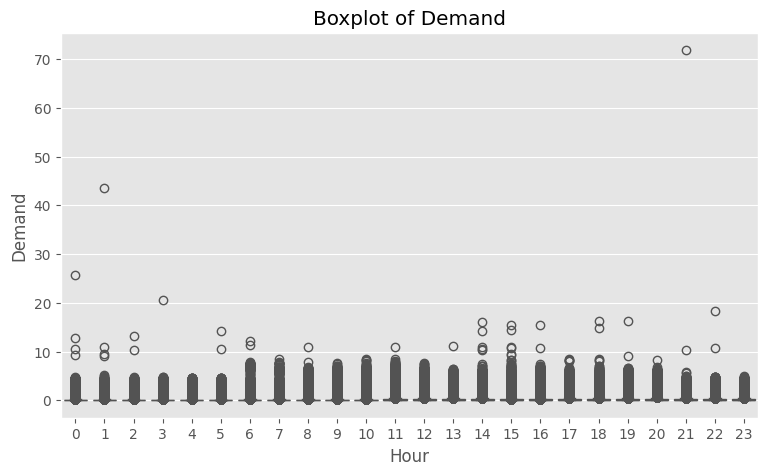

In [ ]:

# Boxplot Demand by Hour
plt.figure(figsize=(9,5))
sns.boxplot(x='Hour', y='Demand', data=df_clear)
plt.title('Boxplot of Demand')
plt.show()


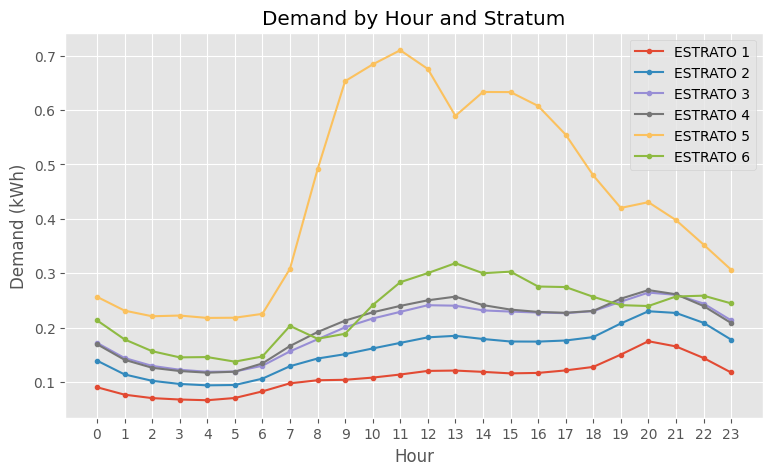

SUBCATEGORIA
ESTRATO 1    5353
ESTRATO 2    3550
ESTRATO 3    2318
ESTRATO 4     815
ESTRATO 5      16
ESTRATO 6      11
Name: PRODUCTO_SERIAL_TWACS, dtype: int64


In [ ]:

# Plot time series Demand by Stratum
df_clear.groupby(['Hour', 'SUBCATEGORIA']).agg({'Demand': 'mean'}).unstack().plot(figsize=(9,5), marker='.')    # Agrupa los datos por hora del día y estrato, y calcula el promedio de demanda por grupo
plt.title('Demand by Hour and Stratum')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(sorted(df_clear['SUBCATEGORIA'].unique()))
plt.show()

print(df_clear.groupby('SUBCATEGORIA')['PRODUCTO_SERIAL_TWACS'].nunique())  # Agrupa por SUBCATEGORIA (estrato) y Calcula cuántos clientes únicos hay en cada uno, usando PRODUCTO_SERIAL_TWACS como identificador del cliente.


#### **Agrupación de la demanda promedio horaria por municipio**

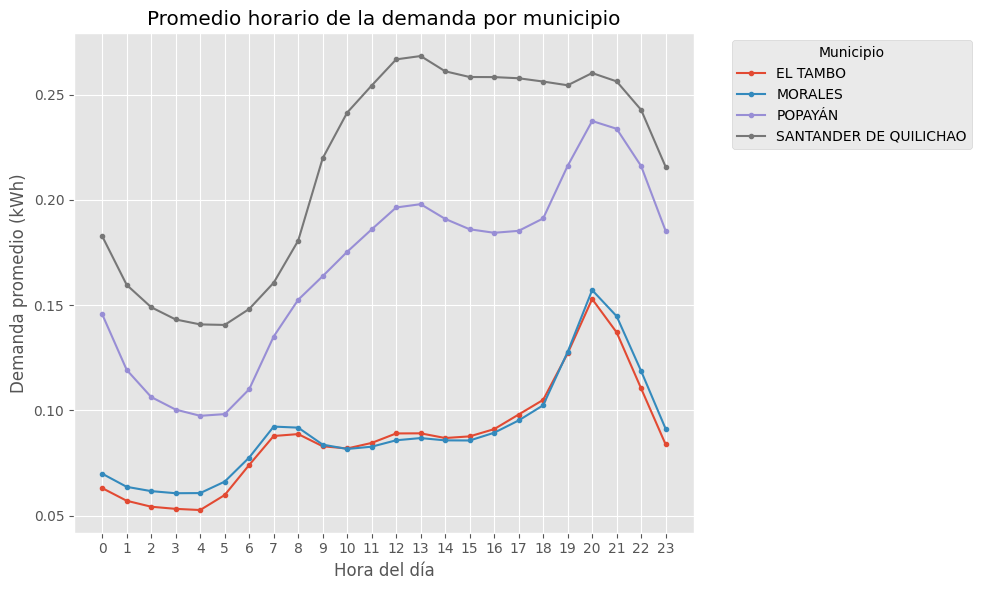

Número de clientes únicos por municipio:
MUNICIPIO
EL TAMBO                  2278
MORALES                   1294
POPAYÁN                   7550
SANTANDER DE QUILICHAO     941
Name: PRODUCTO_SERIAL_TWACS, dtype: int64


In [ ]:

df_avg_municipio = df_clear.groupby(['Hour', 'MUNICIPIO'])['Demand'].mean().unstack()

# Graficar la serie de tiempo
df_avg_municipio.plot(figsize=(10, 6), marker='.')
plt.title('Promedio horario de la demanda por municipio')
plt.xlabel('Hora del día')
plt.ylabel('Demanda promedio (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(title='Municipio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# Conteo de clientes únicos por municipio
clientes_por_municipio = df_clear.groupby('MUNICIPIO')['PRODUCTO_SERIAL_TWACS'].nunique()
print("Número de clientes únicos por municipio:")
print(clientes_por_municipio)


#### **Agrupación de la demanda promedio horaria por tipo de ubicación (rural y urbana)**

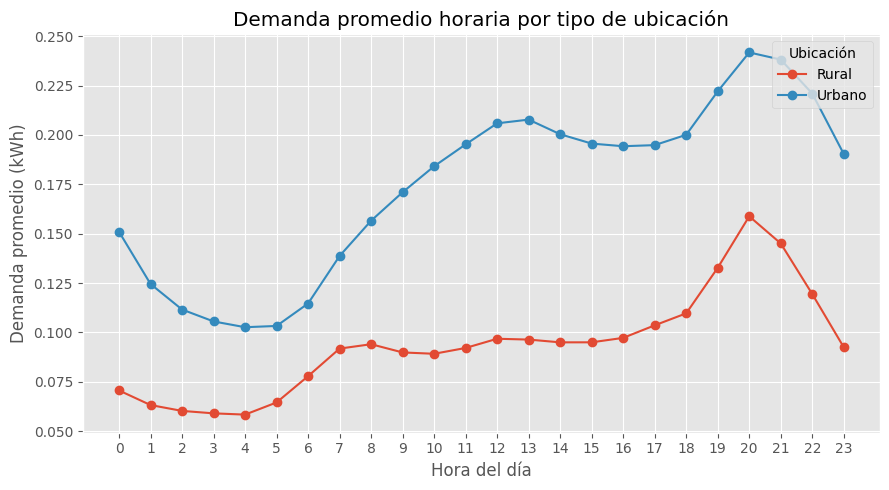

Número de clientes únicos por tipo de ubicación:
UBICACION
Rural     4024
Urbano    8039
Name: PRODUCTO_SERIAL_TWACS, dtype: int64


In [ ]:

df_avg_ubicacion = df_clear.groupby(['Hour', 'UBICACION'])['Demand'].mean().unstack()

# Graficar
df_avg_ubicacion.plot(figsize=(9, 5), marker='o')
plt.title('Demanda promedio horaria por tipo de ubicación')
plt.xlabel('Hora del día')
plt.ylabel('Demanda promedio (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(title='Ubicación', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Conteo de clientes únicos por tipo de ubicación
clientes_por_ubicacion = df_clear.groupby('UBICACION')['PRODUCTO_SERIAL_TWACS'].nunique()
print("Número de clientes únicos por tipo de ubicación:")
print(clientes_por_ubicacion)


In [ ]:

print(df_clear.groupby(['MUNICIPIO', 'UBICACION', 'SUBCATEGORIA'])['PRODUCTO_SERIAL_TWACS'].nunique())      # Cuenta cuántos clientes distintos hay en cada combinación de las tres variables municipio, ubicación y subcategoria.


MUNICIPIO               UBICACION  SUBCATEGORIA
EL TAMBO                Rural      ESTRATO 1       2233
                                   ESTRATO 2         43
                        Urbano     ESTRATO 1          2
MORALES                 Rural      ESTRATO 1       1289
                                   ESTRATO 2          5
POPAYÁN                 Rural      ESTRATO 1        388
                                   ESTRATO 2         59
                                   ESTRATO 3          6
                        Urbano     ESTRATO 1       1318
                                   ESTRATO 2       3294
                                   ESTRATO 3       1646
                                   ESTRATO 4        812
                                   ESTRATO 5         16
                                   ESTRATO 6         11
SANTANDER DE QUILICHAO  Rural      ESTRATO 2          1
                        Urbano     ESTRATO 1        123
                                   ESTRATO 2        148


In [ ]:

print(df_clear['Year_Month'].unique())


['2021-1', '2021-2', '2021-3']
Categories (8, object): ['2020-9' < '2020-10' < '2020-11' < '2020-12' < '2021-1' < '2021-2' < '2021-3' < '2021-4']


#### **Agrupación de los datos año-mes y la media de la demanda para cada combinación**

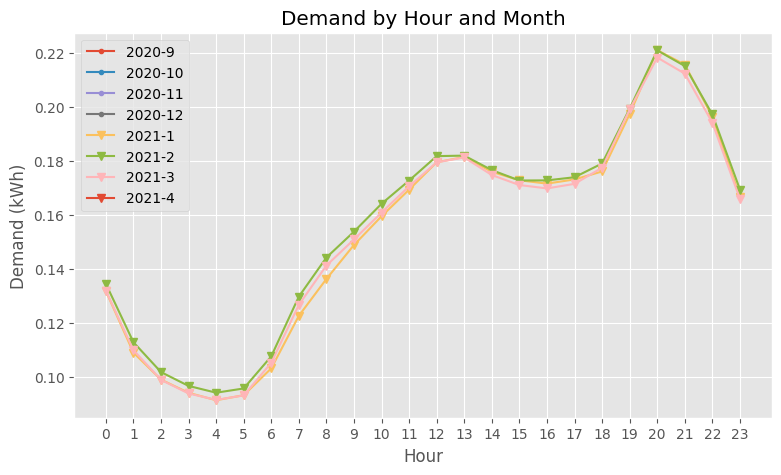

Year_Month
2020-9         0
2020-10        0
2020-11        0
2020-12        0
2021-1     11196
2021-2     11883
2021-3     11991
2021-4         0
Name: PRODUCTO_SERIAL_TWACS, dtype: int64


In [ ]:

agg_df = df_clear.groupby(['Hour', 'Year_Month'])['Demand'].mean().unstack()

markers = ['.','.','.','.','v','v','v','v']     # Definir los marcadores para cada línea

plt.figure(figsize=(9, 5))
for i, (month, marker) in enumerate(zip(agg_df.columns, markers)):
    plt.plot(agg_df.index, agg_df[month], marker=marker, label=month)

plt.title('Demand by Hour and Month')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend()
plt.show()

# Conteo de clientes únicos por mes
print(df_clear.groupby('Year_Month')['PRODUCTO_SERIAL_TWACS'].nunique())       


#### **Agrupación de la demanda promedio horaria por día de la semana (incluyendo festivos)**

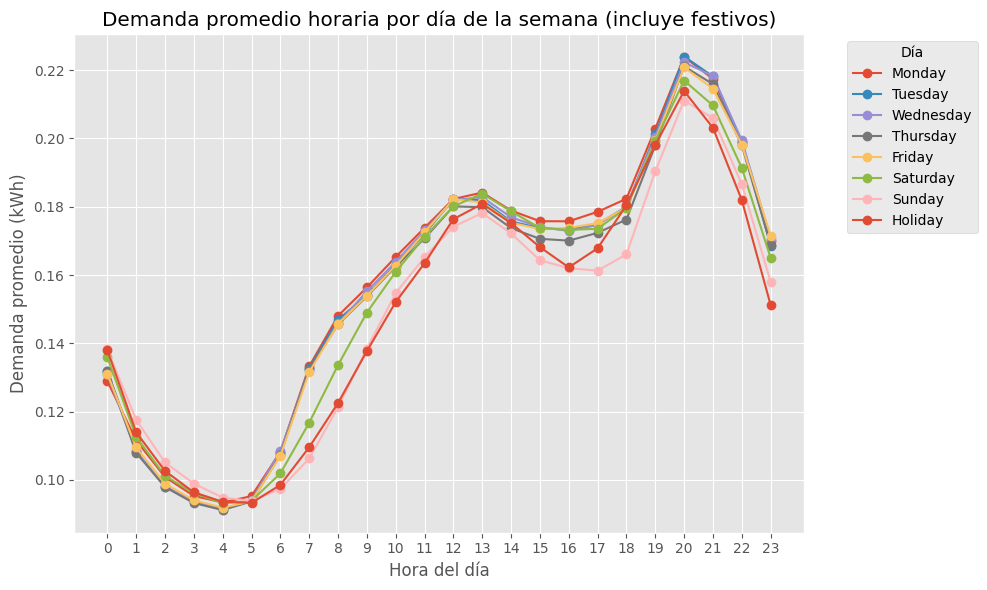

In [ ]:

df_avg_dia_semana = df_clear.groupby(['Hour', 'day_of_week_Holi'])['Demand'].mean().unstack()

# Graficar
df_avg_dia_semana.plot(figsize=(10, 6), marker='o')
plt.title('Demanda promedio horaria por día de la semana (incluye festivos)')
plt.xlabel('Hora del día')
plt.ylabel('Demanda promedio (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(title='Día', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


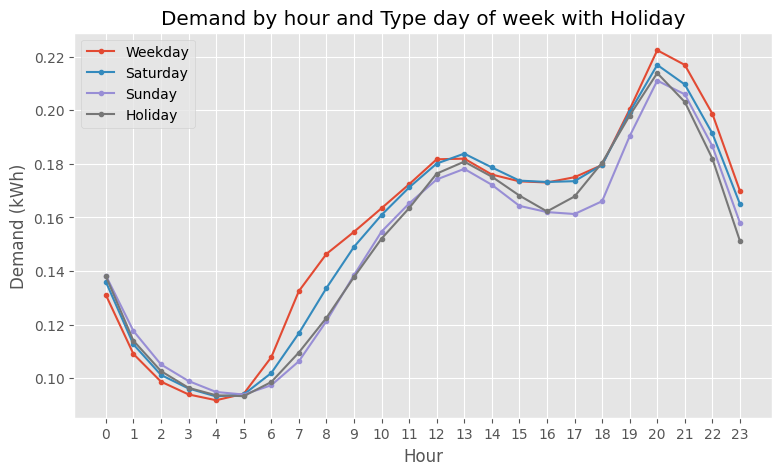

In [ ]:

# Serie temporal de la demanda promedio por hora, agrupada según un tipo de día más general que considera si es día laboral, sábado, domingo o festivo.
df_clear.groupby(['Hour', 'Type_of_day_Holi']).agg({'Demand': 'mean'}).unstack().plot(figsize=(9,5), marker='.')
plt.title('Demand by hour and Type day of week with Holiday')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(['Weekday', 'Saturday', 'Sunday', 'Holiday'])
plt.show()


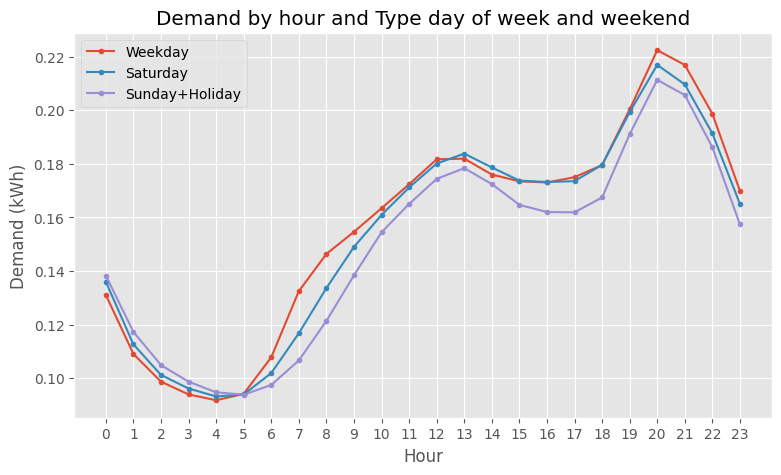

In [ ]:

# Gráfico de series temporales de la demanda eléctrica promedio por hora, diferenciando entre: Días hábiles (Weekday), Sábados (Saturday) y Domingos+festivos (Sunday+Holiday)
df_clear.groupby(['Hour', 'Type_week_weekend']).agg({'Demand': 'mean'}).unstack().plot(figsize=(9,5), marker='.')   
plt.title('Demand by hour and Type day of week and weekend')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(['Weekday', 'Saturday', 'Sunday+Holiday'])
plt.show()


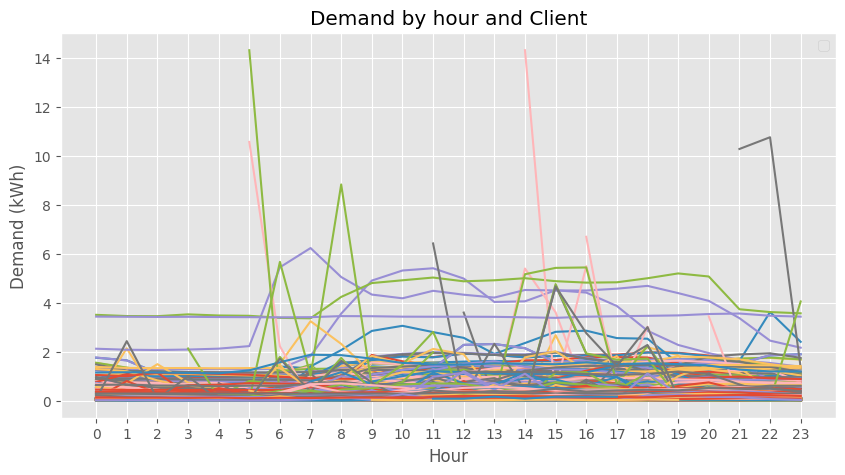

In [ ]:

# Demanda por cliente
df_clear.groupby(['Hour', 'PRODUCTO_SERIAL_TWACS']).agg({'Demand': 'mean'}).unstack().plot(figsize=(10,5))
plt.title('Demand by hour and Client')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend([])
plt.show()


## **ETL 2**

#### **Definir un umbral de consumo promedio horario menor a 2 kWh**

In [ ]:

# Calcular la demanda media horaria por usuario
agg_df = df_clear.groupby(['Hour', 'PRODUCTO_SERIAL_TWACS']).agg({'Demand': 'mean'})
customer_isin = agg_df[agg_df['Demand'] > 2.0].reset_index()['PRODUCTO_SERIAL_TWACS'].unique()
df_clear2 = df_clear[~df_clear['PRODUCTO_SERIAL_TWACS'].isin(customer_isin)]

# Calcular y mostrar el número de clientes eliminados
clientes_totales = df_clear['PRODUCTO_SERIAL_TWACS'].nunique()
clientes_filtrados = df_clear2['PRODUCTO_SERIAL_TWACS'].nunique()
clientes_eliminados = clientes_totales - clientes_filtrados
print(customer_isin.size)


24


In [ ]:

# Seleccionar estratos con mayor cantidad de clientes
df_clear2 = df_clear2[df_clear2['SUBCATEGORIA'].isin(['ESTRATO 1', 'ESTRATO 2', 'ESTRATO 3', 'ESTRATO 4'])]


In [ ]:

print(df_clear2.groupby(['MUNICIPIO', 'UBICACION', 'SUBCATEGORIA'])['PRODUCTO_SERIAL_TWACS'].nunique()) # Calcula la cantidad de clientes únicos


MUNICIPIO               UBICACION  SUBCATEGORIA
EL TAMBO                Rural      ESTRATO 1       2229
                                   ESTRATO 2         43
                        Urbano     ESTRATO 1          2
MORALES                 Rural      ESTRATO 1       1287
                                   ESTRATO 2          5
POPAYÁN                 Rural      ESTRATO 1        387
                                   ESTRATO 2         59
                                   ESTRATO 3          6
                        Urbano     ESTRATO 1       1316
                                   ESTRATO 2       3288
                                   ESTRATO 3       1645
                                   ESTRATO 4        807
SANTANDER DE QUILICHAO  Rural      ESTRATO 2          1
                        Urbano     ESTRATO 1        123
                                   ESTRATO 2        148
                                   ESTRATO 3        664
                                   ESTRATO 4          3


#### **Crear un filtro para eliminar de la combinación 'MUNICIPIO', 'UBICACION' y 'SUBCATEGORIA' conteos con menos de 20 clientes**

In [ ]:

# Contar los valores únicos
counts = df_clear2.groupby(['MUNICIPIO', 'UBICACION', 'SUBCATEGORIA'])['PRODUCTO_SERIAL_TWACS'].nunique().reset_index()

# Filtrar aquellos con conteos mayores o iguales a 20
counts_filtered = counts[counts['PRODUCTO_SERIAL_TWACS'] >= 20]

# Unir el dataframe original con el filtrado
df_clear2 = df_clear2.merge(counts_filtered[['MUNICIPIO', 'UBICACION', 'SUBCATEGORIA']], 
                             on=['MUNICIPIO', 'UBICACION', 'SUBCATEGORIA'], 
                             how='inner')

print(df_clear2.groupby(['MUNICIPIO', 'UBICACION', 'SUBCATEGORIA'])['PRODUCTO_SERIAL_TWACS'].nunique())


MUNICIPIO               UBICACION  SUBCATEGORIA
EL TAMBO                Rural      ESTRATO 1       2229
                                   ESTRATO 2         43
MORALES                 Rural      ESTRATO 1       1287
POPAYÁN                 Rural      ESTRATO 1        387
                                   ESTRATO 2         59
                        Urbano     ESTRATO 1       1316
                                   ESTRATO 2       3288
                                   ESTRATO 3       1645
                                   ESTRATO 4        807
SANTANDER DE QUILICHAO  Urbano     ESTRATO 1        123
                                   ESTRATO 2        148
                                   ESTRATO 3        664
Name: PRODUCTO_SERIAL_TWACS, dtype: int64


#### **Porcentaje de clientes que quedaron del total de usuarios iniciales**

In [ ]:

n1 = df_clear['PRODUCTO_SERIAL_TWACS'].nunique()                # Calcula cuántos clientes únicos había inicialmente en el DataFrame df_clear.
n2 = df_clear2['PRODUCTO_SERIAL_TWACS'].nunique()               # Calcula cuántos clientes únicos quedaron después de los filtros aplicados 
print('Cantidad de clientes iniciales: ', n1)
print('Cantidad de clientes finales: ', n2)
print('Cantidad de clientes excluidos: ', n1-n2)
print('Porcentaje de clientes finales: ', round(n2/n1*100, 2))  # Muestra el porcentaje de clientes que se retuvieron respecto al total inicial


Cantidad de clientes iniciales:  12063
Cantidad de clientes finales:  11996
Cantidad de clientes excluidos:  67
Porcentaje de clientes finales:  99.44


### **Identificación de Fechas faltantes**

In [ ]:

# Crear df con todas las combinaciones de PRODUCTO_SERIAL_TWACS y Fechas
customers = df_clear2['PRODUCTO_SERIAL_TWACS'].unique()  
dates = pd.date_range(start=df_clear2['Date'].min(), end=df_clear2['Date'].max(), freq='H')  # Crea un rango de fechas con frecuencia horaria desde la fecha mínima hasta la máxima del campo 'Date'
customer_dates = pd.MultiIndex.from_product([customers, dates], names=['PRODUCTO_SERIAL_TWACS', 'Date'])    # Crea un MultiIndex con el producto cartesiano entre todos los clientes y todas las horas

all_dates_df = pd.DataFrame(index=customer_dates).reset_index()     # Crea un DataFrame vacío con ese índice. Luego se resetea el índice para que 'PRODUCTO_SERIAL_TWACS' y 'Date' pasen a ser columnas normales.


In [ ]:

print(customers.size)
print(dates.size)
print(all_dates_df.shape)
display(all_dates_df)


11996
1896
(22744416, 2)


PRODUCTO_SERIAL_TWACS                Date
0         652828577_19306164.0 2021-01-12 01:00:00
1         652828577_19306164.0 2021-01-12 02:00:00
2         652828577_19306164.0 2021-01-12 03:00:00
3         652828577_19306164.0 2021-01-12 04:00:00
4         652828577_19306164.0 2021-01-12 05:00:00
...                        ...                 ...
22744411  329405565_63745621.0 2021-03-31 20:00:00
22744412  329405565_63745621.0 2021-03-31 21:00:00
22744413  329405565_63745621.0 2021-03-31 22:00:00
22744414  329405565_63745621.0 2021-03-31 23:00:00
22744415  329405565_63745621.0 2021-04-01 00:00:00

[22744416 rows x 2 columns]

In [ ]:

# Fusiona la tabla con todas las combinaciones cliente-hora (all_dates_df) con los valores reales de demanda en df_clear2
df_merge = pd.merge(all_dates_df, df_clear2[['PRODUCTO_SERIAL_TWACS', 'Date', 'Demand']], how='left', on=['PRODUCTO_SERIAL_TWACS', 'Date'])

# Verificar si hay valores faltantes por cada cliente
missing_per_customer = df_merge.groupby('PRODUCTO_SERIAL_TWACS')['Demand'].apply(lambda x: x.isna().sum())

# Calcular el porcentaje de valores faltantes por cliente
missing_percentage_per_customer = (missing_per_customer / len(dates)) * 100

print("Cliente con mayor cantidad de datos faltantes:")
print("Cliente:", missing_percentage_per_customer.idxmax())                     # Identificar el cliente con el mayor porcentaje de datos faltantes
print("Porcentaje de datos faltantes: {:.1f}%".format(missing_percentage_per_customer[missing_percentage_per_customer.idxmax()]))

print("\nCliente con menor cantidad de datos faltantes:")
print("Cliente:", missing_percentage_per_customer.idxmin())                     # Identificar el cliente con el menor porcentaje de datos faltantes
print("Porcentaje de datos faltantes: {:.1f}%".format(missing_percentage_per_customer[missing_percentage_per_customer.idxmin()]))


Cliente con mayor cantidad de datos faltantes:
Cliente: 251773865_63747392.0
Porcentaje de datos faltantes: 100.0%

Cliente con menor cantidad de datos faltantes:
Cliente: 303093986_63747536.0
Porcentaje de datos faltantes: 3.8%


#### **Crear un filtro para eliminar clientes con más del 35% de datos horarios faltantes**

In [ ]:

# Cantidad total de clientes
n = df_merge['PRODUCTO_SERIAL_TWACS'].unique().size

# Filtrar los clientes que tienen menos del 35% de datos faltantes
Missing = 35.0
filtered_customers = missing_percentage_per_customer[missing_percentage_per_customer <= Missing].index

# Crear un nuevo DataFrame con solo los clientes filtrados
df_clust = df_merge[df_merge['PRODUCTO_SERIAL_TWACS'].isin(filtered_customers)]

# Verificar el nuevo tamaño del DataFrame
print(f"Clientes iniciales:", n)
print("Clientes válidos (Máximo datos faltantes {:.1f}%):".format(Missing), df_clust['PRODUCTO_SERIAL_TWACS'].unique().size)
print("Porcentaje de clientes válidos: {:.1f}%".format(df_clust['PRODUCTO_SERIAL_TWACS'].unique().size/n*100))

df_clust.head(5)


Clientes iniciales: 11996
Clientes válidos (Máximo datos faltantes 35.0%): 5528
Porcentaje de clientes válidos: 46.1%


PRODUCTO_SERIAL_TWACS                Date  Demand
0  652828577_19306164.0 2021-01-12 01:00:00    0.16
1  652828577_19306164.0 2021-01-12 02:00:00    0.24
2  652828577_19306164.0 2021-01-12 03:00:00    0.32
3  652828577_19306164.0 2021-01-12 04:00:00    0.24
4  652828577_19306164.0 2021-01-12 05:00:00    0.32

In [ ]:

df_clust = df_clear2[df_clear2['PRODUCTO_SERIAL_TWACS'].isin(filtered_customers)]


## **Clustering Hour**

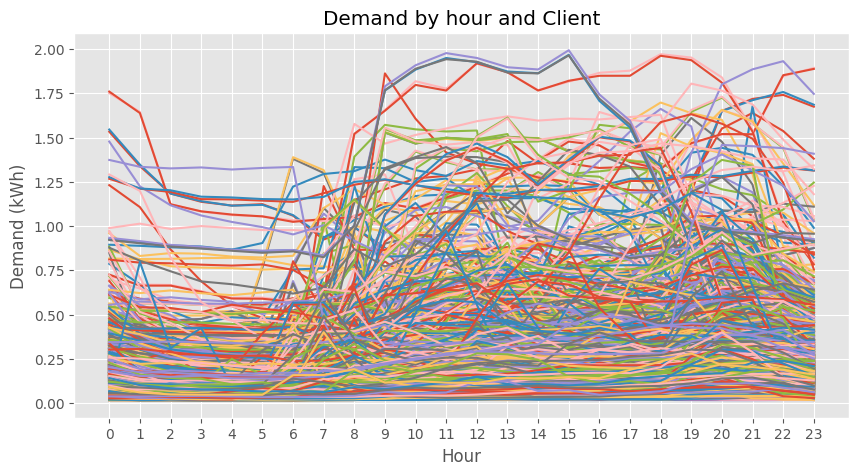

In [ ]:

# Demanda promedio por cliente y hora
clientes_mostrar = df_clust['PRODUCTO_SERIAL_TWACS'].unique()[:]  
df_clust[df_clust['PRODUCTO_SERIAL_TWACS'].isin(clientes_mostrar)].groupby(['Hour', 'PRODUCTO_SERIAL_TWACS']).agg({'Demand': 'mean'}).unstack().plot(figsize=(10,5))
plt.title('Demand by hour and Client')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend().set_visible(False)
plt.show()


### **Definición de Dataframe para aplicar Clustering**

In [ ]:

# df Horas del día (promedio de demanda por hora): filas son clientes (PRODUCTO_SERIAL_TWACS) y las columnas las horas del día.
df_clust_Hour = df_clust.loc[:, ['PRODUCTO_SERIAL_TWACS', 'Hour', 'Demand']]   # Selecciona solo las columnas necesarias
df_clust_Hour_mean0 = df_clust_Hour.groupby(
    ['PRODUCTO_SERIAL_TWACS', 'Hour']).agg({'Demand': 'mean'}).reset_index()   # Calcula la demanda promedio por hora para cada cliente.
df_clust_hour_mean = df_clust_Hour_mean0.pivot(index='PRODUCTO_SERIAL_TWACS', columns='Hour')['Demand']     # Transforma los datos en una matriz cliente × hora, donde cada celda es el valor medio de demanda (kWh) a esa hora para ese cliente.
df_clust_hour_mean = df_clust_hour_mean.sort_index(axis=1)                     # columnas ordenadas cronológicamente

print(df_clust_hour_mean.shape)
display(df_clust_hour_mean.head())


(5528, 24)


Hour                         0         1         2         3         4   \
PRODUCTO_SERIAL_TWACS                                                     
233482980_64621858.0   0.106105  0.067649  0.051143  0.048571  0.055143   
233528905_64620052.0   0.056656  0.042839  0.036721  0.040136  0.042105   
233864854_64622303.0   0.048941  0.037333  0.034182  0.030452  0.028267   
234155072_63750494.0   0.041962  0.032000  0.029760  0.030491  0.027692   
234963793_64621905.0   0.027200  0.031319  0.023333  0.025600  0.025667   

Hour                         5         6         7         8         9   ...  \
PRODUCTO_SERIAL_TWACS                                                    ...   
233482980_64621858.0   0.068945  0.104982  0.117143  0.079719  0.064842  ...   
233528905_64620052.0   0.049723  0.062031  0.067879  0.052848  0.043077  ...   
233864854_64622303.0   0.029288  0.038154  0.035636  0.039619  0.044750  ...   
234155072_63750494.0   0.028571  0.031709  0.027077  0.033481  0.036571  ...   
234963793_64621905.0   0.032923  0.070642  0.079127  0.036160  0.032667  ...   

Hour                         14        15        16        17        18  \
PRODUCTO_SERIAL_TWACS                                                     
233482980_64621858.0   0.053333  0.057825  0.063719  0.089263  0.137263   
233528905_64620052.0   0.072485  0.069970  0.085254  0.102209  0.099343   
233864854_64622303.0   0.056889  0.052431  0.056250  0.049750  0.048955   
234155072_63750494.0   0.058857  0.047407  0.046836  0.056727  0.066000   
234963793_64621905.0   0.053818  0.049846  0.054642  0.036078  0.035925   

Hour                         19        20        21        22        23  
PRODUCTO_SERIAL_TWACS                                                    
233482980_64621858.0   0.229053  0.263298  0.252070  0.214175  0.194807  
233528905_64620052.0   0.116235  0.101412  0.102029  0.089507  0.076500  
233864854_64622303.0   0.064239  0.077176  0.084471  0.075294  0.059059  
234155072_63750494.0   0.073143  0.091228  0.091228  0.085053  0.078596  
234963793_64621905.0   0.099852  0.117818  0.084655  0.056889  0.028549  

[5 rows x 24 columns]

#### **Eliminar clientes con datos faltantes**

In [ ]:

# Número de clientes con al menos un dato faltante en su perfil horario
clientes_con_nan = df_clust_hour_mean.isna().any(axis=1)
num_clientes_con_nan = clientes_con_nan.sum()

print("Número de clientes con datos faltantes en perfil horario:", num_clientes_con_nan)


Número de clientes con datos faltantes en perfil horario: 0


In [ ]:

# Ahora eliminar los que tienen datos faltantes
df_clust_hour_mean_clean = df_clust_hour_mean.dropna()

# Número de clientes restantes después de eliminar los que tienen datos faltantes
num_clientes_restantes = df_clust_hour_mean_clean.shape[0]
print("Número de clientes restantes:", num_clientes_restantes)


Número de clientes restantes: 5528


#### **KMeans**

In [ ]:

Nc = list(range(2,11))                      # Se define un rango de valores k (número de clusters) desde 2 hasta 10 para probar en el clustering.

# Función para preprocesar los datos antes de realizar el clustering (PCA)
def pca(X, nombre_df):
    
    scaler = StandardScaler()               # Estandariza los datos (media=0, desviación=1) antes de aplicar PCA  
    scaler.fit(X)
    X_trans = scaler.transform(X)

    pca_lineal = PCA(n_components=3)        # Aplica PCA y reduce los datos a 3 componentes principales
    pca_lineal.fit(X_trans)
    data_pca = pca_lineal.transform(X_trans)
    df_pca = pd.DataFrame(data_pca)
    df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2', 'PC3'], index=X.index)
    print(f'Varianza explicada {nombre_df}:', pca_lineal.explained_variance_ratio_)     # Muestra la proporción de varianza explicada por cada componente. Si la suma es baja (< 80%), considerar usar más de 3 componentes.
    return df_pca                                                                       

# Función para obtener Davies-Bouldin score con el método KMeans
def DaviesBouldin_KM(X):
    DB_kmeans = {}
    
    for n_clusters in Nc:
        kmeans_model = KMeans(n_clusters=n_clusters, random_state=1, n_init=2).fit(X)       
        labels = kmeans_model.labels_
        DB_kmeans[n_clusters] = davies_bouldin_score(X, labels)         # Calcula el Davies-Bouldin score para cada número de clusters (k)

    df_scores = pd.DataFrame(index=Nc, columns=['kmeans'])              # Crea un DataFrame con los resultados para graficarlos
    df_scores['kmeans'] = DB_kmeans.values()

    return df_scores

# Función para generar la figura asociada al score de Davies-Bouldin
def plot_davies_bouldin_subplot(ax, df, df_name):
    davies_bouldin_scores = DaviesBouldin_KM(df)                # Grafica el Davies-Bouldin score según el número de clusters. Menores valores indican mejor separación y menor dispersión entre clusters.
    ax.plot(Nc, davies_bouldin_scores)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Davies-Bouldin Score')
    ax.set_xticks(Nc)
    ax.text(0.5, 1.1, df_name, transform=ax.transAxes, ha='center')


#### **Sobre los datos utilizar la función definida y aplicar pca para hallar los 3 primeros componentes principales**

Varianza explicada df_clust_hour_mean: [0.76868232 0.09596534 0.04798893]


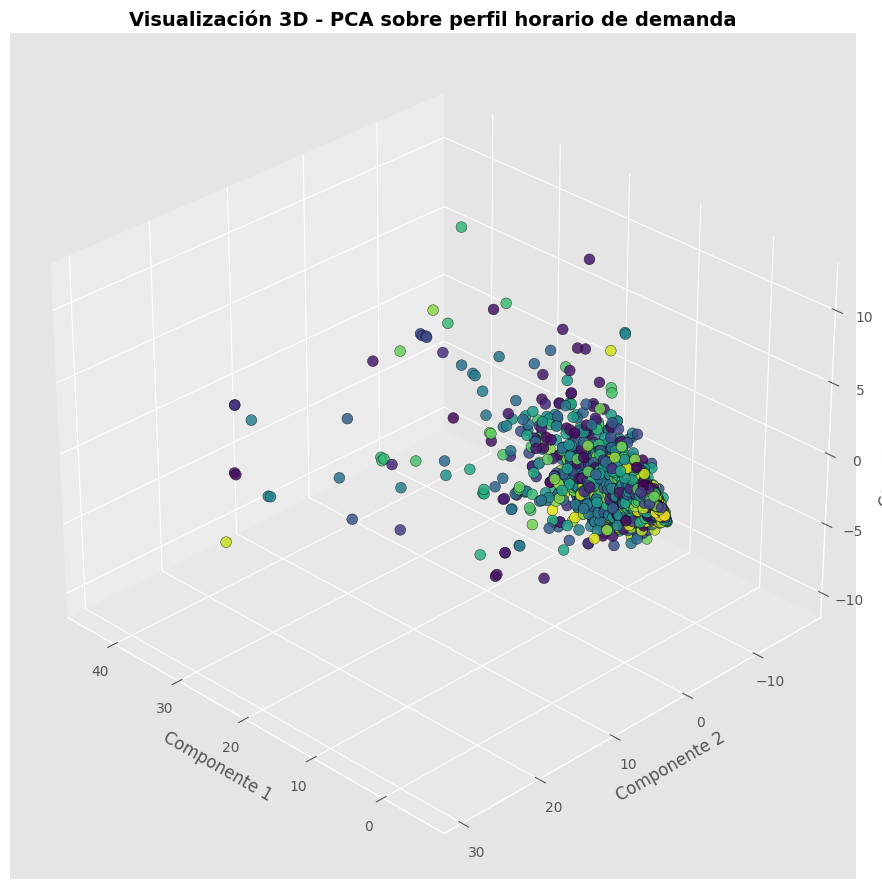

In [ ]:

# Aplicar PCA a los datos
df_pca_hour_mean = pca(df_clust_hour_mean, 'df_clust_hour_mean')

# Crear la figura y el eje 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Generar colores en gradiente
num_points = df_pca_hour_mean.shape[0]
colors = cm.viridis(np.linspace(0, 1, num_points))

# Graficar los puntos en 3D
ax.scatter(
    df_pca_hour_mean['PC1'],
    df_pca_hour_mean['PC2'],
    df_pca_hour_mean['PC3'],
    c=colors,
    s=60,
    alpha=0.85,
    edgecolor='k',
    linewidth=0.3
)

ax.set_xlabel('Componente 1', fontsize=12)
ax.set_ylabel('Componente 2', fontsize=12)
ax.set_zlabel('Componente 3', fontsize=12)
ax.set_title('Visualización 3D - PCA sobre perfil horario de demanda', fontsize=14, fontweight='bold')
ax.view_init(elev=30, azim=135)
ax.grid(True)

plt.tight_layout()
plt.show()


### Identificación de atípicos: Mahalanobis

In [ ]:

data = df_pca_hour_mean[['PC1', 'PC2', 'PC3']].values  # Extrae los valores numéricos de los 3 primeros componentes principales. Crea una matriz data de tamaño 𝑁×3, donde 𝑁 es el número de usuarios.

# Calcular la media y la matriz de covarianza de los datos
mean = np.mean(data, axis=0)  # calcula la media de cada columna (componente principal).
cov = np.cov(data.T)          # calcula la matriz de covarianza de las componentes principales.
inv_cov = inv(cov)            # calcula la inversa de esa matriz de covarianza

# Calcular la distancia de Mahalanobis para cada observación: Itera sobre cada usuario.
distances = cdist(data, [mean], metric='mahalanobis', VI=inv_cov).flatten()
df_pca_hour_mean['mahalanobis_distance'] = distances    # Añade una nueva columna al DataFrame df_pca_hour_mean con la distancia de cada usuario respecto al centro de la nube de datos en el espacio PCA.


In [ ]:

df_pca_hour_mean.head()


PC1       PC2       PC3  mahalanobis_distance
PRODUCTO_SERIAL_TWACS                                                    
233482980_64621858.0  -2.006627  0.837928  0.730035              0.992810
233528905_64620052.0  -3.302707 -0.095977 -0.179345              0.789353
233864854_64622303.0  -3.974207 -0.144587 -0.193250              0.947352
234155072_63750494.0  -4.015468 -0.109804  0.035206              0.938167
234963793_64621905.0  -4.004406 -0.104424 -0.350962              0.990303

In [ ]:

# Umbral estadistico de confianza(95%) (usando distribución Chi-cuadrada): que permite identificar observaciones atípicas en un espacio multivariado.
threshold = chi2.ppf(0.95, df=3)  # Chi-cuadrada para 3 dimensiones (3 grados de libertad) y 95% de nivel de confianza: Solo un 5% de las observaciones más lejanas del centro multivariado (en 3 dimensiones) serán consideradas outliers.

# Filtrar los valores atípicos
outliers = df_pca_hour_mean[df_pca_hour_mean['mahalanobis_distance'] > threshold] # son los usuarios que tienen patrones de demanda estadísticamente inusuales en comparación con el resto, según las componentes principales.

# Eliminar las filas con valores atípicos
df_clean = df_pca_hour_mean[df_pca_hour_mean['mahalanobis_distance'] <= threshold]  # son los usuarios "normales" o representativos que se podrían usar para el clustering sin distorsionar los resultados.

print(f"Cantidad de valores atípicos identificados: {outliers.shape[0]}")


Cantidad de valores atípicos identificados: 52


#### **Identificar las series de tiempo de los clientes identificados como atípicos mediante Mahalanobis**

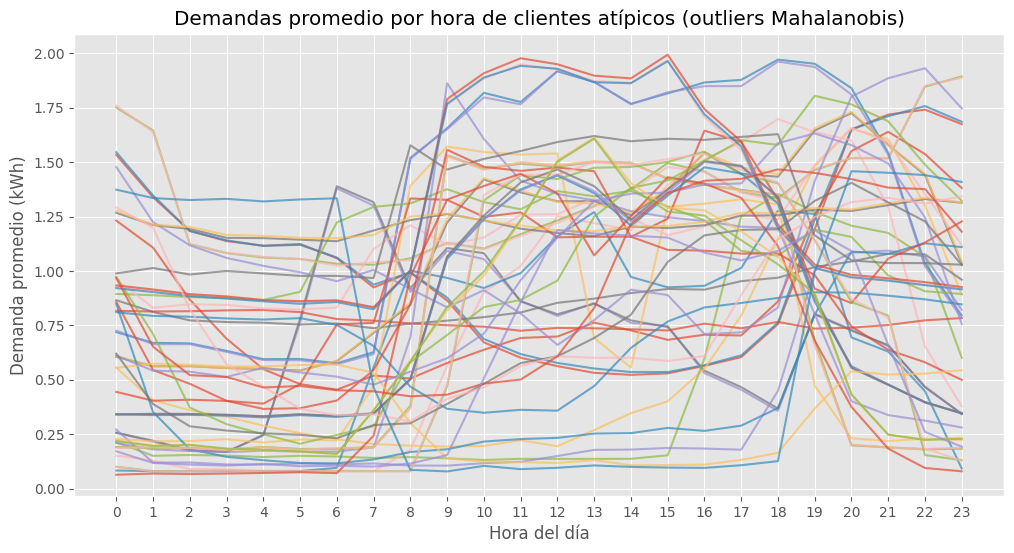

In [ ]:

# Obtener IDs de clientes atípicos
clientes_outliers = outliers.index.tolist()

# Filtrar df_clust para esos clientes atípicos
df_outliers = df_clust[df_clust['PRODUCTO_SERIAL_TWACS'].isin(clientes_outliers)]

# Graficar la demanda horaria promedio de cada outlier
plt.figure(figsize=(12, 6))
for cliente in clientes_outliers:
    data_cliente = df_outliers[df_outliers['PRODUCTO_SERIAL_TWACS'] == cliente]
    demanda_por_hora = data_cliente.groupby('Hour')['Demand'].mean()
    plt.plot(demanda_por_hora.index, demanda_por_hora.values, label=f'Cliente {cliente}', alpha=0.7)

plt.title('Demandas promedio por hora de clientes atípicos (outliers Mahalanobis)')
plt.xlabel('Hora del día')
plt.ylabel('Demanda promedio (kWh)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


#### **Filtrar los clientes que no se identificaron como outliers ni presentaban datos faltantes**

In [ ]:

# Clientes sin outliers y sin datos faltantes
clientes_normales = df_clust_hour_mean_clean.index.difference(clientes_outliers)

# Filtrar df_clust para estos clientes normales
df_clust2 = df_clust[df_clust['PRODUCTO_SERIAL_TWACS'].isin(clientes_normales)]
df_clust2.head(5)


PRODUCTO PRODUCTO_SERIAL_TWACS Start Date             ZONA MUNICIPIO  \
0  652828577  652828577_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
1  648992632  648992632_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
2  652825126  652825126_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
3  652828577  652828577_19306164.0 2021-01-13  S.O ZONA CENTRO   POPAYÁN   
4  648992632  648992632_19306164.0 2021-01-13  S.O ZONA CENTRO   POPAYÁN   

  UBICACION SUBCATEGORIA  Hour  Demand  Year  Month  Day                Date  \
0    Urbano    ESTRATO 2     1    0.16  2021      1   12 2021-01-12 01:00:00   
1    Urbano    ESTRATO 3     1    0.16  2021      1   12 2021-01-12 01:00:00   
2    Urbano    ESTRATO 3     1    0.16  2021      1   12 2021-01-12 01:00:00   
3    Urbano    ESTRATO 2     1    0.32  2021      1   13 2021-01-13 01:00:00   
4    Urbano    ESTRATO 3     1    0.16  2021      1   13 2021-01-13 01:00:00   

  Year_Month day_of_week  Holiday day_of_week_Holi Type_of_day_Holi  \
0     2021-1     Tuesday    False          Tuesday          Weekday   
1     2021-1     Tuesday    False          Tuesday          Weekday   
2     2021-1     Tuesday    False          Tuesday          Weekday   
3     2021-1   Wednesday    False        Wednesday          Weekday   
4     2021-1   Wednesday    False        Wednesday          Weekday   

  Type_week_weekend  
0           Weekday  
1           Weekday  
2           Weekday  
3           Weekday  
4           Weekday

In [ ]:

df_clust2.PRODUCTO_SERIAL_TWACS.nunique()


5476

### Identificación de atípicos: BoxPlot

In [ ]:

#  Método IQR para detectar valores atípicos multivariantes en el espacio de componentes principales.
Q1 = df_pca_hour_mean[['PC1', 'PC2', 'PC3']].quantile(0.25)  # Primer cuartil de cada componente principal
Q3 = df_pca_hour_mean[['PC1', 'PC2', 'PC3']].quantile(0.75)  # Tercer cuartil de cada componente principal
IQR = Q3 - Q1  # Rango intercuartílico

# Define un rango válido de datos
lower_bound = Q1 - 3 * IQR  # Límite inferior para detectar outliers. El factor 3 es más conservador que el típico 1.5, lo cual es útil para datos más ruidosos
upper_bound = Q3 + 3 * IQR  # Límite superior para detectar outliers

# Filtrar los datos fuera de los límites. Aplica las condiciones por columna.
outliers2 = df_pca_hour_mean[((df_pca_hour_mean[['PC1', 'PC2', 'PC3']] < lower_bound) | 
                              (df_pca_hour_mean[['PC1', 'PC2', 'PC3']] > upper_bound)).any(axis=1)] # Identifica como outliers los puntos que se salen de ese rango en alguna de las componentes

usuarios_a_eliminar2 = outliers2.index


#### **Identificar las series de tiempo de los clientes identificados como atípicos mediante el rango intercuartílico**

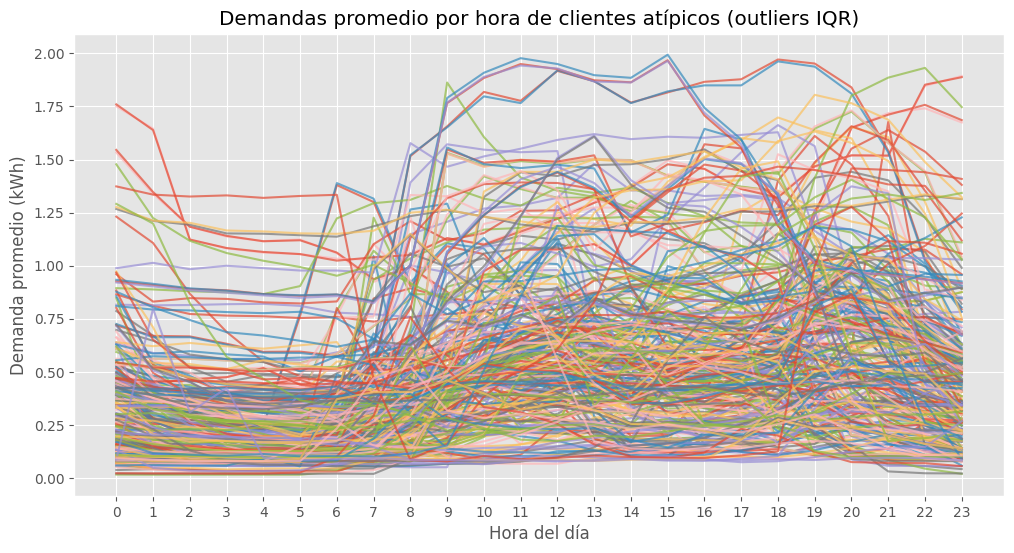

In [ ]:

# IDs de clientes atípicos según IQR
clientes_outliers_iqr = usuarios_a_eliminar2.tolist()

# Filtrar df_clust para esos clientes
df_outliers_iqr = df_clust[df_clust['PRODUCTO_SERIAL_TWACS'].isin(clientes_outliers_iqr)]

plt.figure(figsize=(12, 6))
for cliente in clientes_outliers_iqr:
    data_cliente = df_outliers_iqr[df_outliers_iqr['PRODUCTO_SERIAL_TWACS'] == cliente]
    demanda_por_hora = data_cliente.groupby('Hour')['Demand'].mean()
    plt.plot(demanda_por_hora.index, demanda_por_hora.values, label=f'Cliente {cliente}', alpha=0.7)

plt.title('Demandas promedio por hora de clientes atípicos (outliers IQR)')
plt.xlabel('Hora del día')
plt.ylabel('Demanda promedio (kWh)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


#### **Filtrar clientes que no se identificaron como outliers (IQR) ni presentaban datos faltantes**

In [ ]:

# Clientes sin datos faltantes (usamos df_clust_hour_mean_clean) y sin outliers IQR
clientes_normales_iqr = df_clust_hour_mean_clean.index.difference(clientes_outliers_iqr)

# Filtrar df_clust para esos clientes normales
df_clust2_2 = df_clust[df_clust['PRODUCTO_SERIAL_TWACS'].isin(clientes_normales_iqr)].copy()
df_clust2_2.head(5)


PRODUCTO PRODUCTO_SERIAL_TWACS Start Date             ZONA MUNICIPIO  \
1  648992632  648992632_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
2  652825126  652825126_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
4  648992632  648992632_19306164.0 2021-01-13  S.O ZONA CENTRO   POPAYÁN   
5  652825126  652825126_19306164.0 2021-01-13  S.O ZONA CENTRO   POPAYÁN   
7  648992632  648992632_19306164.0 2021-01-14  S.O ZONA CENTRO   POPAYÁN   

  UBICACION SUBCATEGORIA  Hour  Demand  Year  Month  Day                Date  \
1    Urbano    ESTRATO 3     1    0.16  2021      1   12 2021-01-12 01:00:00   
2    Urbano    ESTRATO 3     1    0.16  2021      1   12 2021-01-12 01:00:00   
4    Urbano    ESTRATO 3     1    0.16  2021      1   13 2021-01-13 01:00:00   
5    Urbano    ESTRATO 3     1    0.16  2021      1   13 2021-01-13 01:00:00   
7    Urbano    ESTRATO 3     1    0.24  2021      1   14 2021-01-14 01:00:00   

  Year_Month day_of_week  Holiday day_of_week_Holi Type_of_day_Holi  \
1     2021-1     Tuesday    False          Tuesday          Weekday   
2     2021-1     Tuesday    False          Tuesday          Weekday   
4     2021-1   Wednesday    False        Wednesday          Weekday   
5     2021-1   Wednesday    False        Wednesday          Weekday   
7     2021-1    Thursday    False         Thursday          Weekday   

  Type_week_weekend  
1           Weekday  
2           Weekday  
4           Weekday  
5           Weekday  
7           Weekday

#### **Encontrar la intercepción entre los clientes detectados como outliers por ambos métodos (Mahalanobis e IQR)**

In [ ]:

# Clientes outliers Mahalanobis
clientes_outliers_maha = outliers.index

# Clientes outliers IQR
clientes_outliers_iqr = usuarios_a_eliminar2

# Intersección de IDs
ID_comunes = set(clientes_outliers_maha).intersection(clientes_outliers_iqr)

print(f"Número de clientes atípicos detectados por ambos métodos: {len(ID_comunes)}")


Número de clientes atípicos detectados por ambos métodos: 52


In [ ]:

# Crear df sin atípicos 
df_clust_hour_mean2 = df_clust_hour_mean.drop(index=ID_comunes)
print(df_clust_hour_mean2.shape)


(5476, 24)


In [ ]:

print(f"Usuarios originales: {df_clust_hour_mean.shape[0]}")
print(f"Usuarios restantes: {df_clust_hour_mean2.shape[0]}")
print(f"Usuarios eliminados: {df_clust_hour_mean.shape[0] - df_clust_hour_mean2.shape[0]}")


Usuarios originales: 5528
Usuarios restantes: 5476
Usuarios eliminados: 52


### **Clustering de Series de Tiempo (por hora) - Forma**

In [ ]:

# Preparación de los datos para aplicar clustering de series temporales usando tslearn
per_hour = TimeSeriesScalerMeanVariance().fit_transform(df_clust_hour_mean2)      # Normaliza cada serie temporal: Media → 0 y Varianza → 1. Es decir, cada fila (usuario) se convierte en una serie temporal estandarizada.
per_hour.shape                                                                    # per_hour es un array de tres dimensiones con forma (n_series, n_timestamps, 1).


(5476, 24, 1)

#### **Identificación de Clusters usando la métrica Davies-Bouldin**

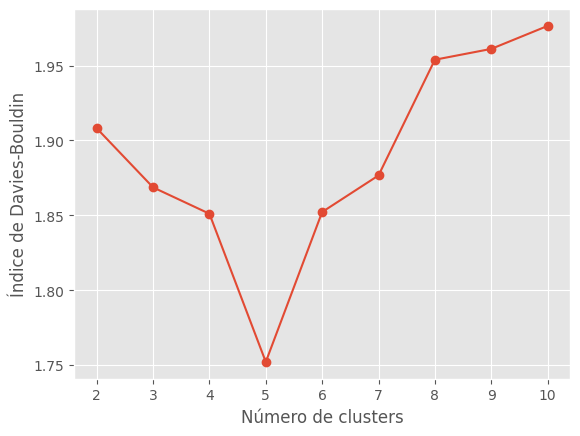

In [ ]:

per_hour_flattened = per_hour.reshape((per_hour.shape[0], -1))

# Evalúa cuántos clusters elegir para un clustering de series temporales con TimeSeriesKMeans, 
# utilizando el índice de Davies-Bouldin (DBI) como métrica de validación
davies_bouldin_scores = []
for k in range(2, 11):                                  # Aplica TimeSeriesKMeans para distintos valores de 𝑘 ∈ [2,10]
    km = TimeSeriesKMeans(n_clusters=k, random_state=0) # Para cada valor de 𝑘: Entrena un modelo TimeSeriesKMeans sobre las series.
    cluster_labels = km.fit_predict(per_hour)           # Obtiene las etiquetas asignadas.
    davies_bouldin_scores.append(davies_bouldin_score(per_hour_flattened, cluster_labels))  # Mide qué tan buenos son los clusters con el DB Score, que penaliza clusters con mucha dispersión o solapamiento.

plt.plot(range(2, 11), davies_bouldin_scores, marker='o')   # Grafica el DBI vs. número de clusters para elegir el k óptimo (menor DBI es mejor).
plt.xlabel('Número de clusters')
plt.ylabel('Índice de Davies-Bouldin')
plt.show()


Euclidean k-means


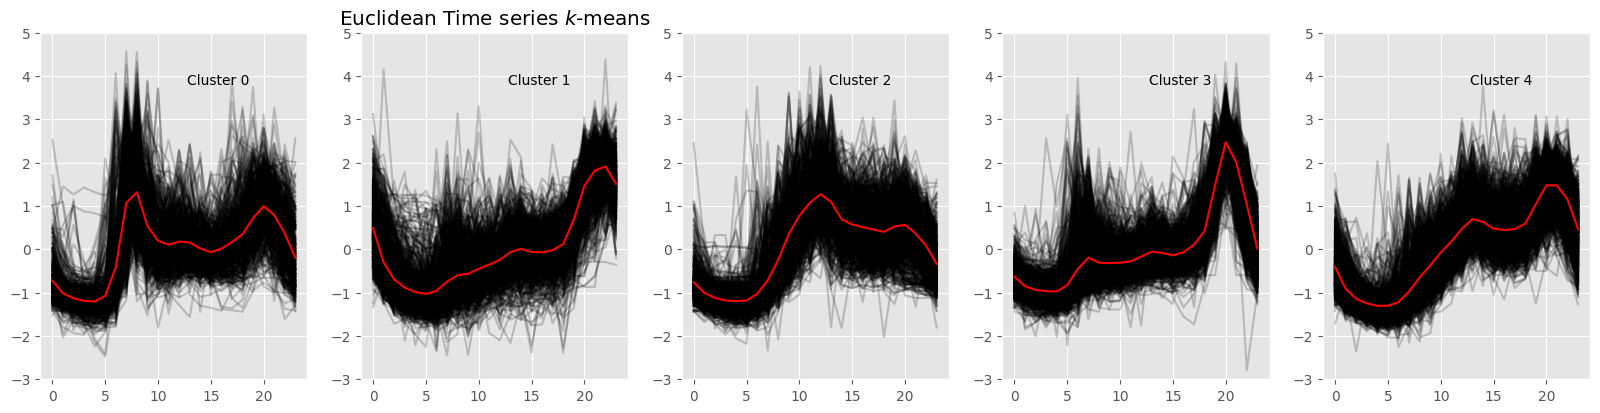

In [ ]:

# Implementa y visualiza un clustering de series temporales usando TimeSeriesKMeans con distancia Euclidiana para 5 clusters
seed = 0
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=5,             
                      verbose=False,
                      random_state=seed,
                      n_jobs=-1)                # Usa todos los núcleos de CPU disponibles (paralelización).
y_pred1 = km.fit_predict(per_hour)              # Entrena el modelo y obtiene las etiquetas predichas (y_pred1) para cada serie.

sz = per_hour.shape[1]

# Crea una figura con 5 subgráficos en una fila, uno por cluster.
fig, axs = plt.subplots(1, 5, figsize=(20, 4.5))
for yi in range(5):
    for xx in per_hour[y_pred1 == yi]:
        axs[yi].plot(xx.ravel(), "k-", alpha=.2)            # Dibuja todas las series que pertenecen al cluster yi en negro y semi-transparente.
    axs[yi].plot(km.cluster_centers_[yi].ravel(), "r-")     # Superpone el centroide del cluster en rojo.
    axs[yi].set_ylim(-3, 5)
    axs[yi].text(0.55, 0.85,'Cluster %d' % (yi),
                 transform=axs[yi].transAxes),
    if yi == 1:
        axs[yi].set_title("Euclidean Time series $k$-means")
        

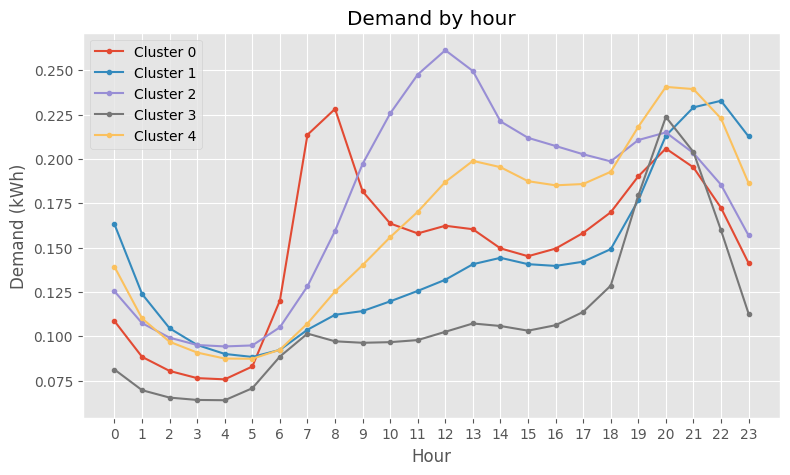

cluster
4    1741
1    1264
3    1182
2     786
0     503
Name: count, dtype: int64


In [ ]:

# Crear un DataFrame con el índice (PRODUCTO_SERIAL_TWACS) y las etiquetas de los clusters
df_clusters = pd.DataFrame({'PRODUCTO_SERIAL_TWACS': df_clust_hour_mean2.index, 'cluster': y_pred1})
df_final_form = pd.merge(df_clust, df_clusters, on='PRODUCTO_SERIAL_TWACS', how='left')
df_final_form['PRODUCTO_SERIAL_TWACS'] = df_final_form['PRODUCTO_SERIAL_TWACS'].astype(str)

# Unir lista de clientes a eliminar
usuarios_totales_eliminar = list(set(usuarios_a_eliminar2).union(set(clientes_con_nan[clientes_con_nan].index)))
usuarios_eliminados_df1 = [str(u) for u in usuarios_totales_eliminar]

# Eliminar esos usuarios
df_final_form = df_final_form[~df_final_form['PRODUCTO_SERIAL_TWACS'].isin(usuarios_eliminados_df1)]

# Convertir cluster a int (si queda alguno NaN deberías manejarlo antes)
df_final_form['cluster'] = df_final_form['cluster'].astype(int)

# Agrupa por Hour y cluster, saca el promedio de demanda y grafica
df_final_form.groupby(['Hour', 'cluster']).agg({'Demand': 'mean'}).unstack().plot(figsize=(9,5), marker='.')
plt.title('Demand by hour')
plt.xlabel('Hour')
plt.ylabel('Demand (kWh)')
plt.xticks(ticks=np.arange(0, 24, 1))
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
plt.show()

# Contar la cantidad de clientes en cada cluster
print(df_clusters['cluster'].value_counts())


#### **Iterar sobre cada clúster y definir nuevas agrupaciones para diferentes valores de k y aplicando clustering mediante TimeSeriesKMeans. Esto ayuda a entender si hay subestructuras (subgrupos) dentro de cada cluster**


Analizando subestructuras en el Cluster 0


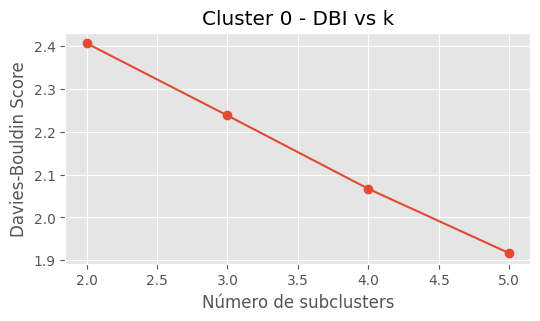

Mejor número de subclusters: 5


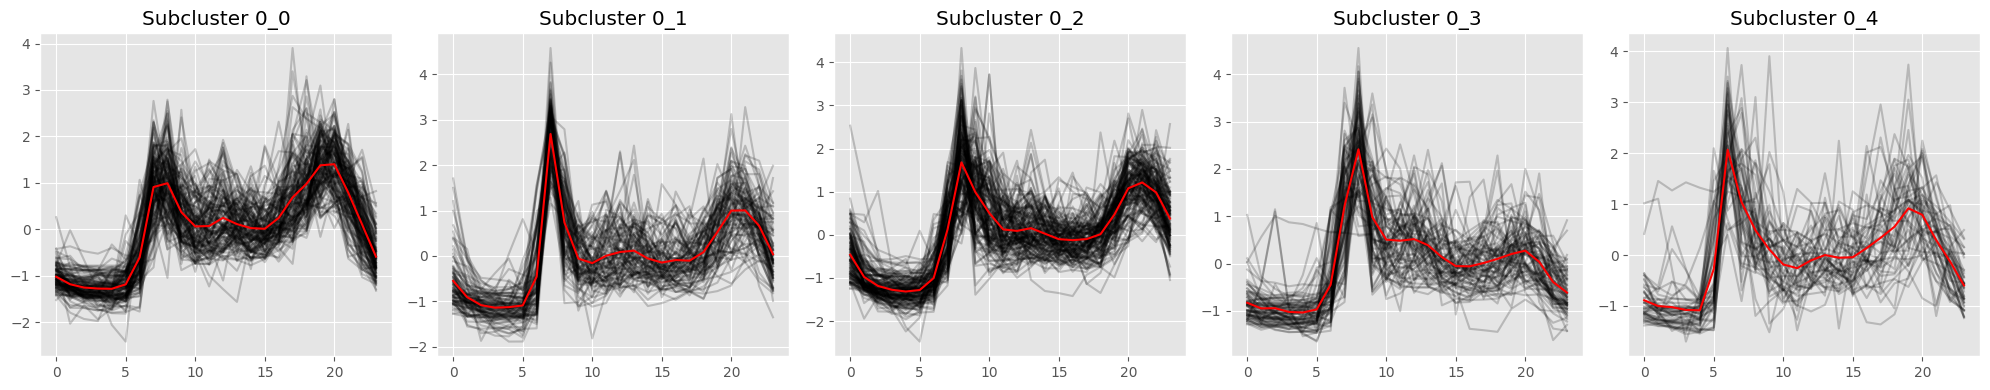


Analizando subestructuras en el Cluster 1


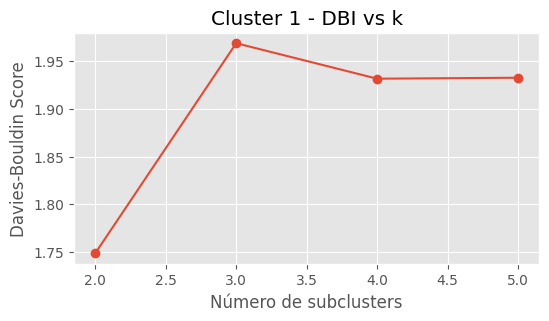

Mejor número de subclusters: 2


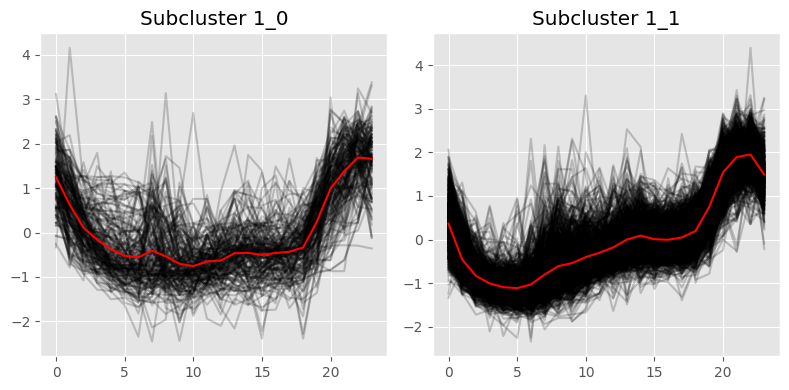


Analizando subestructuras en el Cluster 2


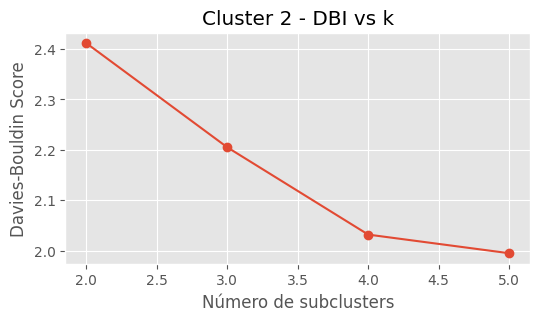

Mejor número de subclusters: 5


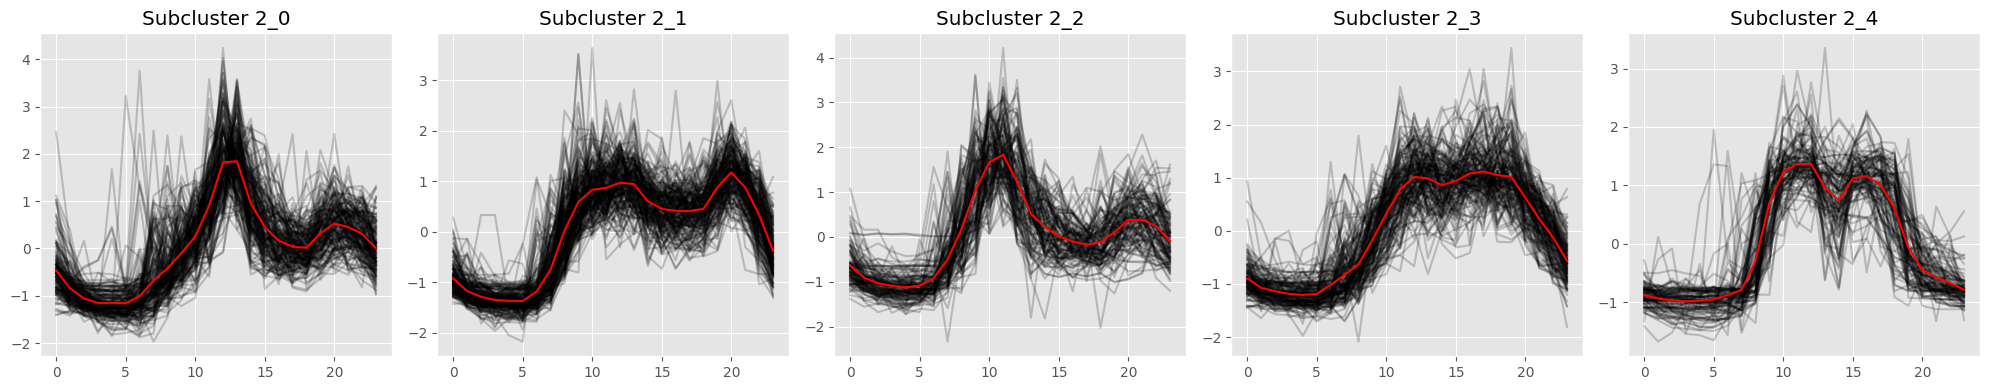


Analizando subestructuras en el Cluster 3


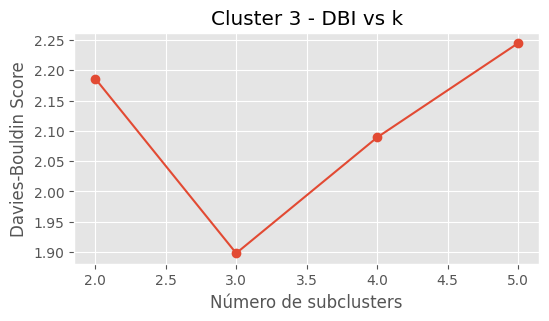

Mejor número de subclusters: 3


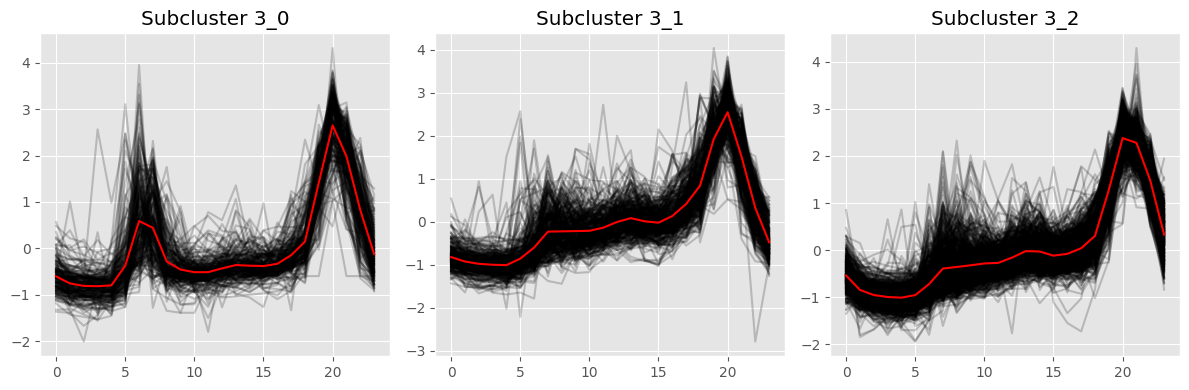


Analizando subestructuras en el Cluster 4


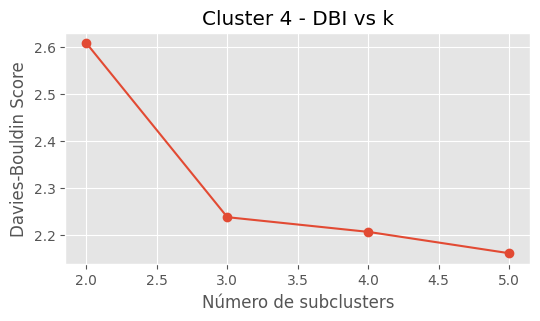

Mejor número de subclusters: 5


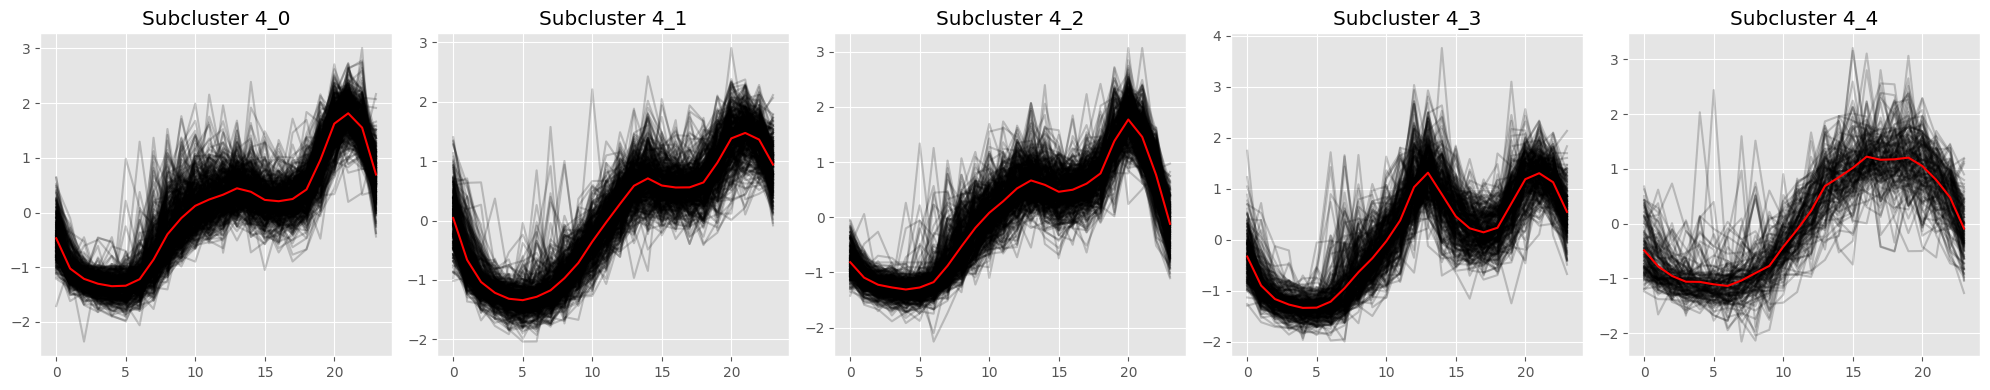

In [ ]:

# Crear la columna 'subcluster' inicialmente como NaN
df_clusters['subcluster'] = np.nan

# Iterar sobre cada cluster original
for c in sorted(df_clusters['cluster'].unique()):
    print(f"\nAnalizando subestructuras en el Cluster {c}")

    # Obtener IDs de clientes en el cluster actual
    clientes_cluster_c = df_clusters[df_clusters['cluster'] == c]['PRODUCTO_SERIAL_TWACS'].values
    df_cluster_c_series = df_clust_hour_mean.loc[clientes_cluster_c]

    # Escalar las series (normalización por serie)
    per_hour_c = TimeSeriesScalerMeanVariance().fit_transform(df_cluster_c_series)
    per_hour_c_flat = per_hour_c.reshape((per_hour_c.shape[0], -1))

    n_users = per_hour_c.shape[0]
    if n_users < 3:
        print("No hay suficientes usuarios para subagrupamiento.")
        continue

    # Probar diferentes valores de k para subclustering interno
    db_scores = []
    ks = range(2, min(6, n_users))  # Limitar k a máximo 5 o menos si hay pocos usuarios

    for k in ks:
        km = TimeSeriesKMeans(n_clusters=k, random_state=0)
        labels = km.fit_predict(per_hour_c)
        score = davies_bouldin_score(per_hour_c_flat, labels)
        db_scores.append(score)

    # Mostrar gráfica de DBI vs k
    plt.figure(figsize=(6, 3))
    plt.plot(ks, db_scores, marker='o')
    plt.title(f'Cluster {c} - DBI vs k')
    plt.xlabel('Número de subclusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.grid(True)
    plt.show()

    # Seleccionar mejor k (mínimo DBI)
    best_k = ks[np.argmin(db_scores)]
    print(f"Mejor número de subclusters: {best_k}")

    # Aplicar subclustering final con mejor k
    km_final = TimeSeriesKMeans(n_clusters=best_k, random_state=0)
    sub_labels = km_final.fit_predict(per_hour_c)

    # Asignar etiquetas de subcluster en formato: "cluster_subcluster" (ej: 2_1)
    subcluster_ids = [f"{c}_{sub}" for sub in sub_labels]
    df_clusters.loc[df_clusters['PRODUCTO_SERIAL_TWACS'].isin(clientes_cluster_c), 'subcluster'] = subcluster_ids

    # Visualizar centroides de subclusters
    fig, axs = plt.subplots(1, best_k, figsize=(4 * best_k, 4))
    for sub in range(best_k):
        for xx in per_hour_c[sub_labels == sub]:
            axs[sub].plot(xx.ravel(), "k-", alpha=.2)
        axs[sub].plot(km_final.cluster_centers_[sub].ravel(), "r-")
        axs[sub].set_title(f"Subcluster {c}_{sub}")
    plt.tight_layout()
    plt.show()
    

In [ ]:

df_clusters.head()


PRODUCTO_SERIAL_TWACS  cluster subcluster
0  233482980_64621858.0        3        3_0
1  233528905_64620052.0        3        3_1
2  233864854_64622303.0        4        4_0
3  234155072_63750494.0        1        1_1
4  234963793_64621905.0        3        3_0

In [ ]:

# Asegurarse de que subcluster es tipo string
df_clusters['subcluster'] = df_clusters['subcluster'].astype(str)

# Hacer merge para agregar la columna 'subcluster' al dataframe completo
df_final_form = pd.merge(
    df_final_form, 
    df_clusters[['PRODUCTO_SERIAL_TWACS', 'subcluster']], 
    on='PRODUCTO_SERIAL_TWACS',
    how='left'
)

# Guardar el DataFrame en un archivo CSV
df_final_form.to_csv('df_final.csv', index=False)


In [ ]:

df_final_form.head()


PRODUCTO PRODUCTO_SERIAL_TWACS Start Date             ZONA MUNICIPIO  \
0  648992632  648992632_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
1  652825126  652825126_19306164.0 2021-01-12  S.O ZONA CENTRO   POPAYÁN   
2  648992632  648992632_19306164.0 2021-01-13  S.O ZONA CENTRO   POPAYÁN   
3  652825126  652825126_19306164.0 2021-01-13  S.O ZONA CENTRO   POPAYÁN   
4  648992632  648992632_19306164.0 2021-01-14  S.O ZONA CENTRO   POPAYÁN   

  UBICACION SUBCATEGORIA  Hour  Demand  Year  ...  Day                Date  \
0    Urbano    ESTRATO 3     1    0.16  2021  ...   12 2021-01-12 01:00:00   
1    Urbano    ESTRATO 3     1    0.16  2021  ...   12 2021-01-12 01:00:00   
2    Urbano    ESTRATO 3     1    0.16  2021  ...   13 2021-01-13 01:00:00   
3    Urbano    ESTRATO 3     1    0.16  2021  ...   13 2021-01-13 01:00:00   
4    Urbano    ESTRATO 3     1    0.24  2021  ...   14 2021-01-14 01:00:00   

  Year_Month day_of_week Holiday  day_of_week_Holi Type_of_day_Holi  \
0     2021-1     Tuesday   False           Tuesday          Weekday   
1     2021-1     Tuesday   False           Tuesday          Weekday   
2     2021-1   Wednesday   False         Wednesday          Weekday   
3     2021-1   Wednesday   False         Wednesday          Weekday   
4     2021-1    Thursday   False          Thursday          Weekday   

  Type_week_weekend cluster_x  cluster_y  
0           Weekday         1          1  
1           Weekday         4          4  
2           Weekday         1          1  
3           Weekday         4          4  
4           Weekday         1          1  

[5 rows x 21 columns]